<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/07_UpdateNeuralNetwork_Incomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install jcopml

In [ ]:
! pip install jcopdl

In [ ]:
! pip install luwiji

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [167]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/03_Training_df2.csv')

In [168]:
df.head()

case_num  days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
0         0     0  0.000000            0.0             0            0.00   
1         0    31  0.084932        26614.0        825035         1740.71   
2         0    62  0.169863        21427.7       1489290         1740.71   
3         0    93  0.254795        18809.7       2072390         1740.71   
4         0   124  0.339726        16676.6       2589370         1740.71   

   water_inj_cum category      Kh_Kv     inj_rate  permeability  porosity  \
0            0.0    train  16.423475  1740.711355    288.983333  0.163009   
1        53962.1    train  16.423475  1740.711355    288.983333  0.163009   
2       107924.0    train  16.423475  1740.711355    288.983333  0.163009   
3       161886.0    train  16.423475  1740.711355    288.983333  0.163009   
4       215848.0    train  16.423475  1740.711355    288.983333  0.163009   

     prod_bhp  thickness  
0  796.992254  23.718632  
1  796.992254  23.718632  
2  796.992254  23.718632  
3  796.992254  23.718632  
4  796.992254  23.718632

In [169]:
df.describe()

case_num          days         years  oil_prod_rate  oil_prod_cum  \
count  83000.000000  83000.000000  83000.000000   83000.000000  8.300000e+04   
mean     499.500000   1271.000000      3.482192    8518.148043  1.683427e+07   
std      288.676729    742.711684      2.034827   14514.871036  1.032644e+07   
min        0.000000      0.000000      0.000000       0.000000  0.000000e+00   
25%      249.750000    620.000000      1.698630    2176.710000  8.882572e+06   
50%      499.500000   1271.000000      3.482192    3148.885000  1.518575e+07   
75%      749.250000   1922.000000      5.265753    7946.767500  2.299825e+07   
max      999.000000   2542.000000      6.964384  213798.000000  5.488200e+07   

       water_inj_rate  water_inj_cum         Kh_Kv      inj_rate  \
count    83000.000000   8.300000e+04  83000.000000  83000.000000   
mean      1956.933478   2.517595e+06     51.023587   1980.798623   
std        607.650760   1.694638e+06     28.320724    571.375444   
min          0.000000   0.000000e+00      1.117770   1001.361112   
25%       1467.150000   1.134448e+06     26.465307   1490.288876   
50%       1964.650000   2.294485e+06     51.084696   1974.114748   
75%       2468.610000   3.643210e+06     74.961078   2470.503903   
max       2999.050000   7.623580e+06     99.582172   2999.048260   

       permeability      porosity      prod_bhp     thickness  
count  83000.000000  83000.000000  83000.000000  83000.000000  
mean     276.200395      0.200145    608.556951     54.297994  
std      129.506627      0.057515    228.882923     26.344904  
min       50.622464      0.100380    200.456940     10.071005  
25%      166.173993      0.150198    417.234602     31.280914  
50%      272.801457      0.200421    609.768186     53.629173  
75%      389.900501      0.249404    807.944162     78.315422  
max      499.479880      0.299785    999.951688     99.956295

In [170]:
df['oil_prod_cum_10e5'] = df['oil_prod_cum'] / 100000

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83000 entries, 0 to 82999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   case_num           83000 non-null  int64  
 1   days               83000 non-null  int64  
 2   years              83000 non-null  float64
 3   oil_prod_rate      83000 non-null  float64
 4   oil_prod_cum       83000 non-null  int64  
 5   water_inj_rate     83000 non-null  float64
 6   water_inj_cum      83000 non-null  float64
 7   category           83000 non-null  object 
 8   Kh_Kv              83000 non-null  float64
 9   inj_rate           83000 non-null  float64
 10  permeability       83000 non-null  float64
 11  porosity           83000 non-null  float64
 12  prod_bhp           83000 non-null  float64
 13  thickness          83000 non-null  float64
 14  oil_prod_cum_10e5  83000 non-null  float64
dtypes: float64(11), int64(3), object(1)
memory usage: 9.5+ MB


In [172]:
df.set_index('case_num', inplace=True)

In [173]:
X = df.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category', 'oil_prod_cum_10e5'])
y = df.oil_prod_cum_10e5 #For convert this value from DataFrame to Array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

#Sample Data

In [128]:
X.head()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
0         0.000000  16.423475  1740.711355    288.983333  0.163009   
0         0.084932  16.423475  1740.711355    288.983333  0.163009   
0         0.169863  16.423475  1740.711355    288.983333  0.163009   
0         0.254795  16.423475  1740.711355    288.983333  0.163009   
0         0.339726  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [129]:
X_train #X_train is still in DataFrame format

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
770       1.953425  76.562427  1501.989069    110.332224  0.166387   
551       5.775342  33.531889  2184.997903    362.046424  0.125779   
903       1.783562  89.631066  2567.620088    497.802419  0.227672   
514       4.586301  10.538772  2724.213947    424.023854  0.250540   
843       6.200000  20.574319  2325.046378    398.503028  0.287599   
...            ...        ...          ...           ...       ...   
75        3.397260  63.893187  1255.113759    105.108028  0.192954   
661       1.953425  65.897649  2094.213287    135.554003  0.148714   
925       3.821918  22.048879  1608.098583    302.867957  0.251251   
10        2.547945  45.562823  1039.504281     88.312606  0.262261   
190       2.123288  88.825897  1840.143125    238.984924  0.260408   

            prod_bhp  thickness  
case_num                         
770       792.275187  61.990466  
551       212.009954  17.283933  
903       572.556817  77.151446  
514       369.128064  79.152487  
843       698.555363  69.626309  
...              ...        ...  
75        628.373327  52.211811  
661       340.120810  54.321268  
925       576.046120  16.034091  
10        566.346366  50.182736  
190       908.627866  27.356139  

[62250 rows x 7 columns]

In [130]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'minmax'), X_train.columns)
])

In [131]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [174]:
#This step can be skipped if we have performed the two step above

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [95]:
y_train #now the data is converted into array

array([117.178 ,  83.3404, 294.689 , ...,  83.0529, 124.586 ,  96.8314])

---------------------------------------------

#STEP 1: DATASET & DATALOADER
Data loader --> aims to create the mini batch

In [175]:
import torch
from torch. utils.data import DataLoader, TensorDataset

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [177]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [178]:
# Create dataset (train & test) with the tensor data above and also create dataloader 
train_set = TensorDataset (X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

In [179]:
train_set[:5]

(tensor([[1.9534e+00, 7.6562e+01, 1.5020e+03, 1.1033e+02, 1.6639e-01, 7.9228e+02,
          6.1990e+01],
         [5.7753e+00, 3.3532e+01, 2.1850e+03, 3.6205e+02, 1.2578e-01, 2.1201e+02,
          1.7284e+01],
         [1.7836e+00, 8.9631e+01, 2.5676e+03, 4.9780e+02, 2.2767e-01, 5.7256e+02,
          7.7151e+01],
         [4.5863e+00, 1.0539e+01, 2.7242e+03, 4.2402e+02, 2.5054e-01, 3.6913e+02,
          7.9152e+01],
         [6.2000e+00, 2.0574e+01, 2.3250e+03, 3.9850e+02, 2.8760e-01, 6.9856e+02,
          6.9626e+01]]),
 tensor([117.1780,  83.3404, 294.6890, 387.2940, 367.1870]))

-----------------------------------------------------------

#**Step 2 : Architecture and Configuration**

In [180]:
#import neural network
from torch import nn

In [181]:
# Design Neural Network Architecture
nn.Sequential(
    nn.Linear(7, 8),
    nn.ReLU(), #ACTIVATION IN THE HIDDEN LAYER. IN THIS LAYER, THE ACTIVATION COULD BE ANY FUNCTION EXCEPT IDENTITY
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Identity()  #FUNCTION IDENTITY IS USED FOR REGRESION CASE. FOR OTHER CASE (CLASSIFICATION), PLEASE USE OTHER FUNCTION
)

Sequential(
  (0): Linear(in_features=7, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Identity()
)

------------------------------------------------

#**Step 3: Training Preparation**
Prepare model, criterion, and optimizer

##Model

In [182]:
model = nn.Sequential(
    nn.Linear(7, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
    nn.Identity()
)

-------------------

##Criterion
Criterion is the function that use to calculate the loss/error of our prediction

In [183]:
criterion = nn.MSELoss() #MSEloss (Mean Square Error) loss --> ofcourse it is for regression case

------------

#Optimizer
Optimizer references

- https://www.deeplearning.ai/ai-notes/optimization/?utm_source=social&utm_medium=linkedin&utm_campaign=BlogAlNotesOptimizationAugust272019
- https://github.com/Jaewan-Yun/optimizer-visualization

In [24]:
from luwiji.neural_network import illustration, demo

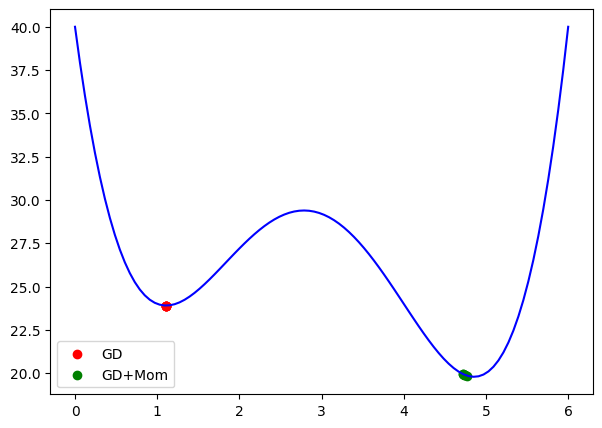

In [39]:
demo.momentum()

In [185]:
# Set optimizer for the model
from torch import optim

In [184]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

---------------------------------

#**Step 4: Training Loop**

In [186]:
#Training and Testing cost

epochs = 10
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) # feed forward
        target = target.unsqueeze(1)
        loss  = criterion(output, target)
        loss.backward() # Backpropagation

        optimizer.step # update weight
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
    
    with torch.no_grad():    #For data testing: No backpropagation, so we don't have to update weight
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) # feed forward
            target = target.unsqueeze(1)
            loss  = criterion(output, target)
            
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))
        
        
    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end =" ")

Epoch:   10/  10 | train_cost: 44041.5727 | test_cost: 43571.7710 

In [148]:
import matplotlib.pyplot as plt

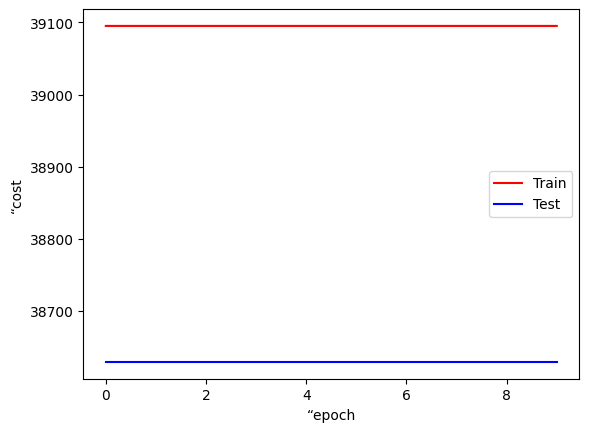

In [149]:
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
plt.xlabel("“epoch"); plt.ylabel("“cost"); plt.legend();

In [145]:
#Prediksi

with torch.no_grad():
    model.eval()
    output = model(X_test)

In [146]:
output.shape

torch.Size([20750, 1])

------------

#**Minimize overfit with drop out**

Explanation: for each iteration, there are a neuron in each layer that neglicted during the training model. It can improve the model accuracy and reduce the ovefit

In [43]:
from luwiji.neural_network import illustration

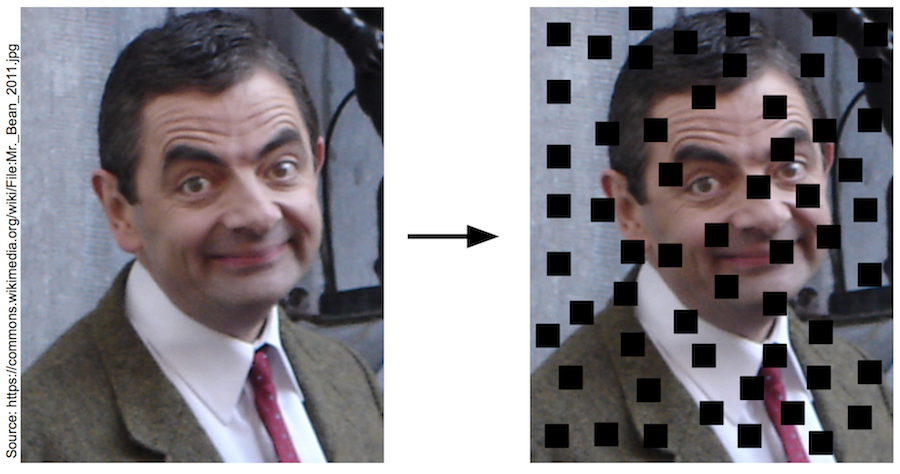

In [44]:
illustration.dropout_idea

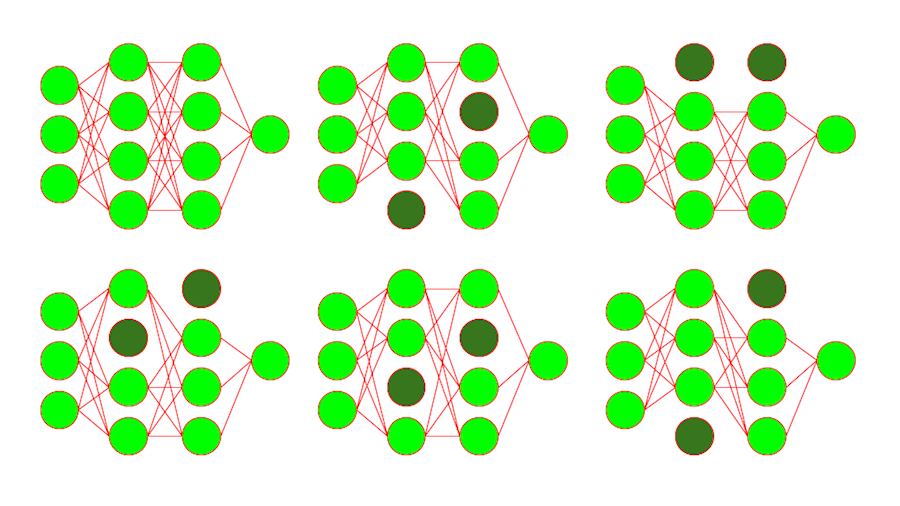

In [46]:
illustration.dropout

In [164]:
model = nn.Sequential(
    nn.Linear(7, 8),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(4, 1),
    nn.Identity()
)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [165]:
#Training and Testing cost

epochs = 10
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) # feed forward
        target = target.unsqueeze(1)
        loss  = criterion(output, target)
        loss.backward() # Backpropagation

        optimizer.step # update weight
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
    
    with torch.no_grad():    #For data testing: No backpropagation, so we don't have to update weight
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) # feed forward
            target = target.unsqueeze(1)
            loss  = criterion(output, target)
            
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))
        
        
    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end =" ")

Epoch:   10/  10 | train_cost: 39027.6565 | test_cost: 38555.6401 

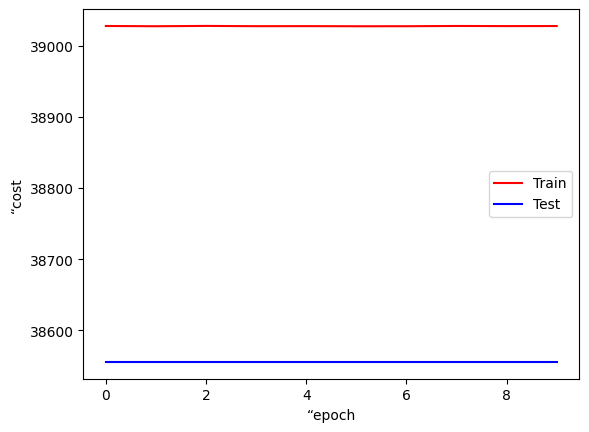

In [166]:
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
plt.xlabel("“epoch"); plt.ylabel("“cost"); plt.legend();

In [187]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model (feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    #acc = correct / len(dataset) Ignore if the case = regression, apply if the case = classification
    return cost #,acc

In [157]:
epochs = 30
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs):
    cost, acc = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
        cost, acc = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f"\rEpoch:{i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}) | "
          f"train_acc: {train_acc[-1]:.4f} | test_acc: {test_acc[-1]:.4f}", end = " ")

Epoch:30/30 | train_cost: 13040.8061 | test_cost: 10849.2590) | train_acc: 0.0122 | test_acc: 0.0116 

In [191]:
epochs = 100
train_cost, test_cost = [], []
for i in range(epochs):
    cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    with torch.no_grad():
        cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        
    print(f"\rEpoch:{i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end=" ")


Epoch:100/100 | train_cost: 20278.3632 | test_cost: 19915.9133 

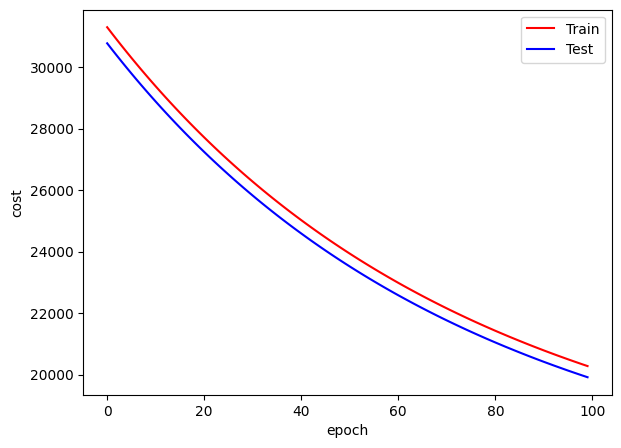

In [192]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label = "Train")
plt.plot(test_cost, 'b-', label = "Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

In [29]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation
    total_loss = 0

    for feature, target in testloader:
        output = model(feature)  # Forward pass
        loss = criterion(output, target)  # Calculate the loss/error
        total_loss += loss.item() * feature.size(0)  # Accumulate the loss

    mse = total_loss / len(testloader.dataset)  # Calculate the mean MSE

print(f"MSE: {mse}")


MSE: 27899.365769013555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Create empty lists to store the actual and predicted values
y_train_actual = []
y_train_predicted = []
y_test_actual = []
y_test_predicted = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation
    for feature, target in trainloader:
        output = model(feature)  # Forward pass
        y_train_actual.extend(target.numpy())  # Append actual values to the list
        y_train_predicted.extend(output.numpy())  # Append predicted values to the list

    for feature, target in testloader:
        output = model(feature)  # Forward pass
        y_test_actual.extend(target.numpy())  # Append actual values to the list
        y_test_predicted.extend(output.numpy())  # Append predicted values to the list

# Convert the lists to numpy arrays
y_train_actual = np.array(y_train_actual)
y_train_predicted = np.array(y_train_predicted)
y_test_actual = np.array(y_test_actual)
y_test_predicted = np.array(y_test_predicted)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train_actual, 'Predicted': y_train_predicted})
test_data = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_test_predicted})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0], s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (SVM)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train_actual.max(), y_test_actual.max())], [0, max(y_train_actual.max(), y_test_actual.max())],
             color='black', linestyle='-')

# Add R-squared score as text inside the plot
train_r2 = r2_score(y_train_actual, y_train_predicted)
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (SVM)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train_actual.max(), y_test_actual.max())], [0, max(y_train_actual.max(), y_test_actual.max())],
             color='black', linestyle='-')

test_r2 = r2_score(y_test_actual, y_test_predicted)
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white


SyntaxError: ignored

In [388]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [389]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson'), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=20, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


{'algo__max_depth': 69, 'algo__max_features': 0.6962700559185838, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 105}
0.999907862539124 0.9993808244760873 0.9996641594101543


In [390]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_V2.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_V2.pkl']

In [391]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best_V2.pkl'

import joblib

# Save the trained model to a file
joblib.dump(model_RF.best_estimator_, file_path)

['/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best_V2.pkl']

In [193]:
file_path = '/content/drive/MyDrive/00_History_Matching/Model_/model_RF_Cum_OilProd_Best_V2.pkl'

import joblib

# Load the specific model
model_RF = joblib.load(file_path)

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [197]:
df1 = df.copy()
df1.head()

days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
case_num                                                                
0            0  0.000000            0.0             0            0.00   
0           31  0.084932        26614.0        825035         1740.71   
0           62  0.169863        21427.7       1489290         1740.71   
0           93  0.254795        18809.7       2072390         1740.71   
0          124  0.339726        16676.6       2589370         1740.71   

          water_inj_cum category      Kh_Kv     inj_rate  permeability  \
case_num                                                                 
0                   0.0    train  16.423475  1740.711355    288.983333   
0               53962.1    train  16.423475  1740.711355    288.983333   
0              107924.0    train  16.423475  1740.711355    288.983333   
0              161886.0    train  16.423475  1740.711355    288.983333   
0              215848.0    train  16.423475  1740.711355    288.983333   

          porosity    prod_bhp  thickness  oil_prod_cum_10e5  
case_num                                                      
0         0.163009  796.992254  23.718632            0.00000  
0         0.163009  796.992254  23.718632            8.25035  
0         0.163009  796.992254  23.718632           14.89290  
0         0.163009  796.992254  23.718632           20.72390  
0         0.163009  796.992254  23.718632           25.89370

In [198]:
X = df1.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category', 'oil_prod_cum_10e5'])
y = df1.oil_prod_cum_10e5 #For convert this value from DataFrame to Array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

In [199]:
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

In [201]:
train_mse = mean_squared_error(y_train, y_train_pred)
train_mse

0.9860990698332078

In [203]:
test_mse = mean_squared_error(y_test, y_test_pred)
test_mse

3.5416332628084093

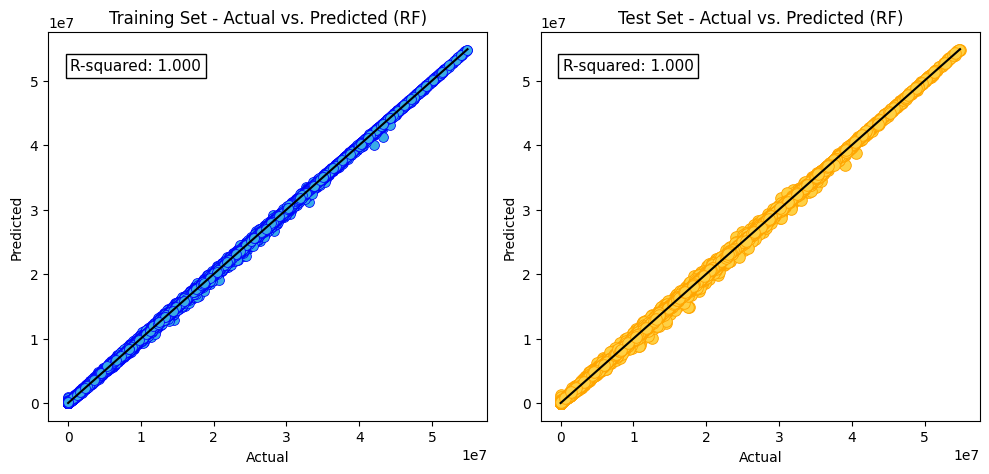

In [222]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='blue')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='orange')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

#**TEST DATA PREDICTION**

In [12]:
# Obtain predictions for the test dataset
y_test_pred = model_RF.predict(X_test)

In [14]:
comparison_test_df = pd.DataFrame({'Predicted': y_test_pred, 'Actual': y_test})
comparison_test_df.head()

Predicted    Actual
case_num                        
588        7905.944103   7782.62
391        2463.340069   2457.39
773        5642.163500   5126.19
775        1461.539027   1467.06
879       10942.997035  10041.70

In [15]:
# Concatenate comparison_df with X_test
concatenated_test_df = pd.concat([X_test, comparison_test_df], axis=1)

concatenated_test_df.head()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
588       1.358904  55.671093  1072.948149    322.005237  0.296478   
391       6.200000  17.743045  1327.831513    230.685909  0.298417   
773       1.528767  91.594717  1210.373574    496.644528  0.243255   
775       4.416438   6.324609  1251.987121    329.811040  0.235667   
879       1.189041  84.097055  2424.864587    251.993775  0.136780   

            prod_bhp  thickness     Predicted    Actual  
case_num                                                 
588       974.812075  21.998831   7905.944103   7782.62  
391       459.303415  93.661558   2463.340069   2457.39  
773       763.475551  31.259883   5642.163500   5126.19  
775       786.512041  38.828670   1461.539027   1467.06  
879       866.797466  56.402386  10942.997035  10041.70

#**TRAINING DATA PREDICTION**

In [16]:
# Obtain predictions for the training dataset
y_train_pred = model_RF.predict(X_train)

In [17]:
comparison_train_df = pd.DataFrame({'Predicted': y_train_pred, 'Actual': y_train})
comparison_train_df.head()

Predicted    Actual
case_num                        
207        1334.917542   1325.52
779       32425.678949  31759.10
783        2612.355729   2617.35
638        2127.240878   2130.44
138        1570.055084   1571.16

In [18]:
# Concatenate comparison_df with X_train
concatenated_train_df = pd.concat([X_train, comparison_train_df], axis=1)

concatenated_train_df.head()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
207       4.756164  53.430458  1164.225717    210.578313  0.169661   
779       0.169863  30.180537  1683.703882    293.308471  0.159314   
783       3.227397  42.195767  1491.226913    393.795810  0.232694   
638       6.030137  62.283845  1887.808774    276.374370  0.267304   
138       4.756164  23.878544  1525.459004    405.047106  0.184826   

            prod_bhp  thickness     Predicted    Actual  
case_num                                                 
207       513.893676  34.327362   1334.917542   1325.52  
779       472.891708  32.006569  32425.678949  31759.10  
783       521.133493  86.997859   2612.355729   2617.35  
638       424.747788  53.609024   2127.240878   2130.44  
138       513.829693  78.662629   1570.055084   1571.16

#**DATASET PREDICTION**

In [392]:
df_pred = model_RF.predict(X)

In [393]:
df_predict = pd.DataFrame({'Predicted': df_pred, 'Actual': y})

In [394]:
df_prediction = pd.concat([X, df_predict], axis=1)

In [395]:
df_prediction.tail()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
999       6.624658  29.653913  1998.328914    160.051346  0.197521   
999       6.709589  29.653913  1998.328914    160.051346  0.197521   
999       6.794521  29.653913  1998.328914    160.051346  0.197521   
999       6.879452  29.653913  1998.328914    160.051346  0.197521   
999       6.964384  29.653913  1998.328914    160.051346  0.197521   

            prod_bhp  thickness   Predicted   Actual  
case_num                                              
999       353.949063  62.922681  256.039974  256.278  
999       353.949063  62.922681  257.177636  256.996  
999       353.949063  62.922681  257.495348  257.709  
999       353.949063  62.922681  257.627472  258.416  
999       353.949063  62.922681  257.627472  259.119

In [396]:
df_prediction = df_prediction.reset_index(drop = False)

In [397]:
# Get unique values in the "case_num" column
unique_cases = df_prediction['case_num'].unique()

# Initialize an empty DataFrame to store the sorted data
df_prediction2 = pd.DataFrame()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    case_data = df_prediction[df_prediction['case_num'] == case]
    # Sort the data based on the "days" column
    sorted_case_data = case_data.sort_values(by="years")
    # Drop the first row from the sorted data
    sorted_case_data = sorted_case_data.drop(sorted_case_data.index[0])
    # Append the sorted data to the overall sorted DataFrame
    df_prediction2 = pd.concat([df_prediction2, sorted_case_data], ignore_index=True)


In [398]:
df_prediction2.loc[df_prediction['case_num'] == 12].tail()

case_num     years      Kh_Kv     inj_rate  permeability  porosity  \
1074        13  0.764384  81.656518  1244.689219    201.998281  0.266884   
1075        13  0.849315  81.656518  1244.689219    201.998281  0.266884   
1076        13  0.934247  81.656518  1244.689219    201.998281  0.266884   
1077        13  1.019178  81.656518  1244.689219    201.998281  0.266884   
1078        13  1.104110  81.656518  1244.689219    201.998281  0.266884   

       prod_bhp  thickness  Predicted   Actual  
1074  607.01423  17.833764  35.106114  33.4229  
1075  607.01423  17.833764  37.197667  36.2023  
1076  607.01423  17.833764  39.981507  38.8444  
1077  607.01423  17.833764  42.243359  41.3571  
1078  607.01423  17.833764  44.479597  43.7481

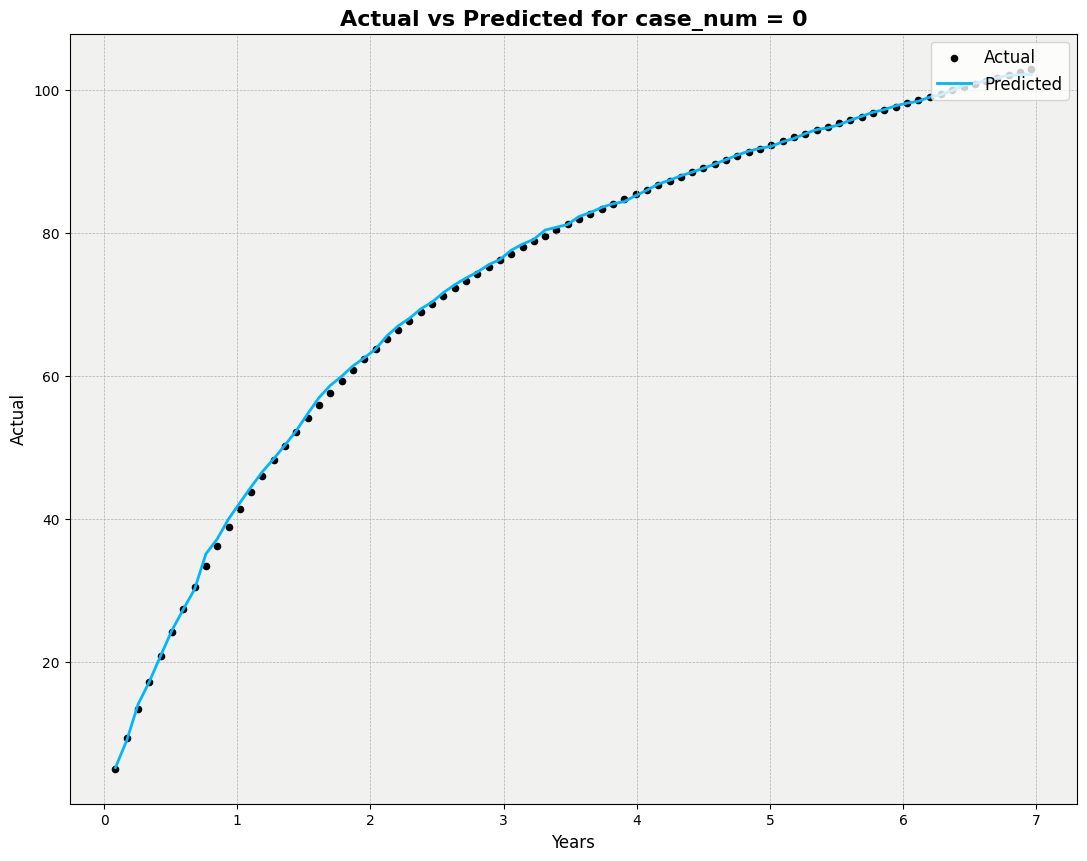

In [399]:
import matplotlib.pyplot as plt

plot_1 = df_prediction2[df_prediction2['case_num'] == 13]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Actual', marker='o')

# Plot line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='#00b7fb', linewidth=2, label='Predicted')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Predicted for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

#**VALIDATION**

In [400]:
df_validation = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/04_Validation_df2.csv')

In [401]:
df_validation.head()

case_num  days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
0         0  2573  7.049315        1790.12      10181500         1740.71   
1         0  2604  7.134247        1790.09      10237000         1740.71   
2         0  2635  7.219178        1790.07      10292500         1740.71   
3         0  2666  7.304110        1790.03      10348000         1740.71   
4         0  2697  7.389041        1789.99      10403500         1740.71   

   water_inj_cum category      Kh_Kv     inj_rate  permeability  porosity  \
0      4478850.0    train  16.423475  1740.711355    288.983333  0.163009   
1      4532810.0    train  16.423475  1740.711355    288.983333  0.163009   
2      4586770.0    train  16.423475  1740.711355    288.983333  0.163009   
3      4640740.0    train  16.423475  1740.711355    288.983333  0.163009   
4      4694700.0    train  16.423475  1740.711355    288.983333  0.163009   

     prod_bhp  thickness  
0  796.992254  23.718632  
1  796.992254  23.718632  
2  796.992254  23.718632  
3  796.992254  23.718632  
4  796.992254  23.718632

In [402]:
df_validation['oil_prod_cum_10e5'] = df_validation['oil_prod_cum'] / 100000

In [403]:
pred = df_validation.copy()

In [404]:
pred.drop(columns = ['days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category', 'oil_prod_rate', 'oil_prod_cum_10e5'], inplace = True)

In [405]:
pred.set_index('case_num', inplace=True)
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   years         38000 non-null  float64
 1   Kh_Kv         38000 non-null  float64
 2   inj_rate      38000 non-null  float64
 3   permeability  38000 non-null  float64
 4   porosity      38000 non-null  float64
 5   prod_bhp      38000 non-null  float64
 6   thickness     38000 non-null  float64
dtypes: float64(7)
memory usage: 2.3 MB


In [406]:
X.head()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
0         0.000000  16.423475  1740.711355    288.983333  0.163009   
0         0.084932  16.423475  1740.711355    288.983333  0.163009   
0         0.169863  16.423475  1740.711355    288.983333  0.163009   
0         0.254795  16.423475  1740.711355    288.983333  0.163009   
0         0.339726  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [407]:
pred.head()

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
0         7.049315  16.423475  1740.711355    288.983333  0.163009   
0         7.134247  16.423475  1740.711355    288.983333  0.163009   
0         7.219178  16.423475  1740.711355    288.983333  0.163009   
0         7.304110  16.423475  1740.711355    288.983333  0.163009   
0         7.389041  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [408]:
y_pred = model_RF.predict(pred)

In [417]:
R2_score = r2_score(df_validation.oil_prod_cum_10e5, y_pred)
R2_score

0.971230459380918

In [418]:
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error
mae = mean_absolute_error(df_validation['oil_prod_cum_10e5'], y_pred)

# Print the mean absolute error
print("Mean Absolute Error:", mae)

Mean Absolute Error: 14.925761374025376


In [411]:
val_pred = df_validation.copy()
val_pred['Predicted_cum_oil'] = y_pred

In [416]:
val_pred[val_pred['case_num'] == 1].tail()

case_num  days      years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
71         1  3596   9.852055        2558.09      27448400          2217.0   
72         1  3627   9.936986        2547.44      27527400          2217.0   
73         1  3658  10.021918        2537.19      27606100          2217.0   
74         1  3689  10.106849        2527.32      27684400          2217.0   
75         1  3720  10.191781        2517.83      27762500          2217.0   

    water_inj_cum category      Kh_Kv     inj_rate  permeability  porosity  \
71      7972320.0    train  96.690954  2216.996775    127.801703  0.265198   
72      8041050.0    train  96.690954  2216.996775    127.801703  0.265198   
73      8109770.0    train  96.690954  2216.996775    127.801703  0.265198   
74      8178500.0    train  96.690954  2216.996775    127.801703  0.265198   
75      8247230.0    train  96.690954  2216.996775    127.801703  0.265198   

      prod_bhp  thickness  oil_prod_cum_10e5  Predicted_cum_oil  
71  672.408364   50.10332            274.484         243.181405  
72  672.408364   50.10332            275.274         243.181405  
73  672.408364   50.10332            276.061         243.181405  
74  672.408364   50.10332            276.844         243.181405  
75  672.408364   50.10332            277.625         243.181405

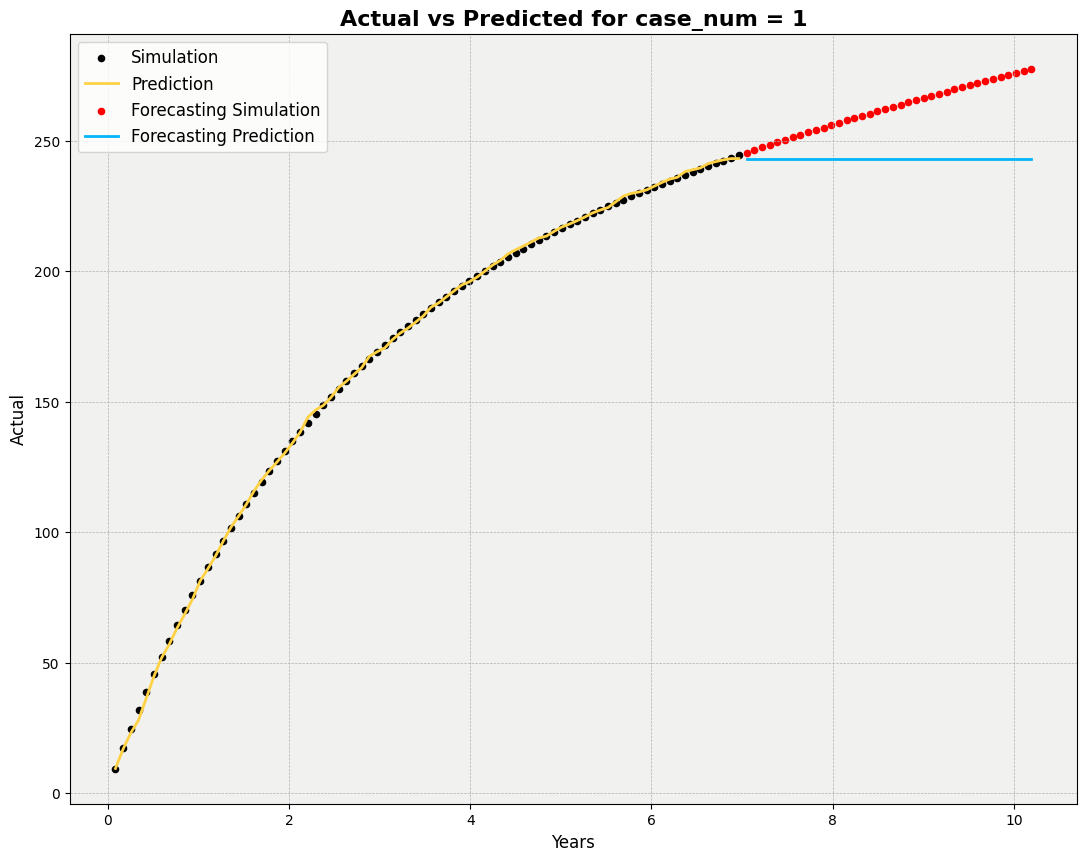

In [414]:
|plot_1 = df_prediction2[df_prediction2['case_num'] == 1]
plot_2 = val_pred[val_pred['case_num'] == 1]

case_num_value = plot_1['case_num'].unique()[0]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot1 scatter for "Actual" column
ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Simulation', marker='o')

# Plot1 line for "Predicted" column
ax1.plot(plot_1['years'], plot_1['Predicted'], color='#ffd145', linewidth=2, label='Prediction')


# Plot2 scatter for "Actual" column
ax1.scatter(plot_2['years'], plot_2['oil_prod_cum_10e5'], color='red', s=20, label='Forecasting Simulation', marker='o')

# Plot2 line for "Predicted" column
ax1.plot(plot_2['years'], plot_2['Predicted_cum_oil'], color='#00b7fb', linewidth=2, label='Forecasting Prediction')

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title(f'Actual vs Predicted for case_num = {case_num_value}', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper left', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')

plt.show()

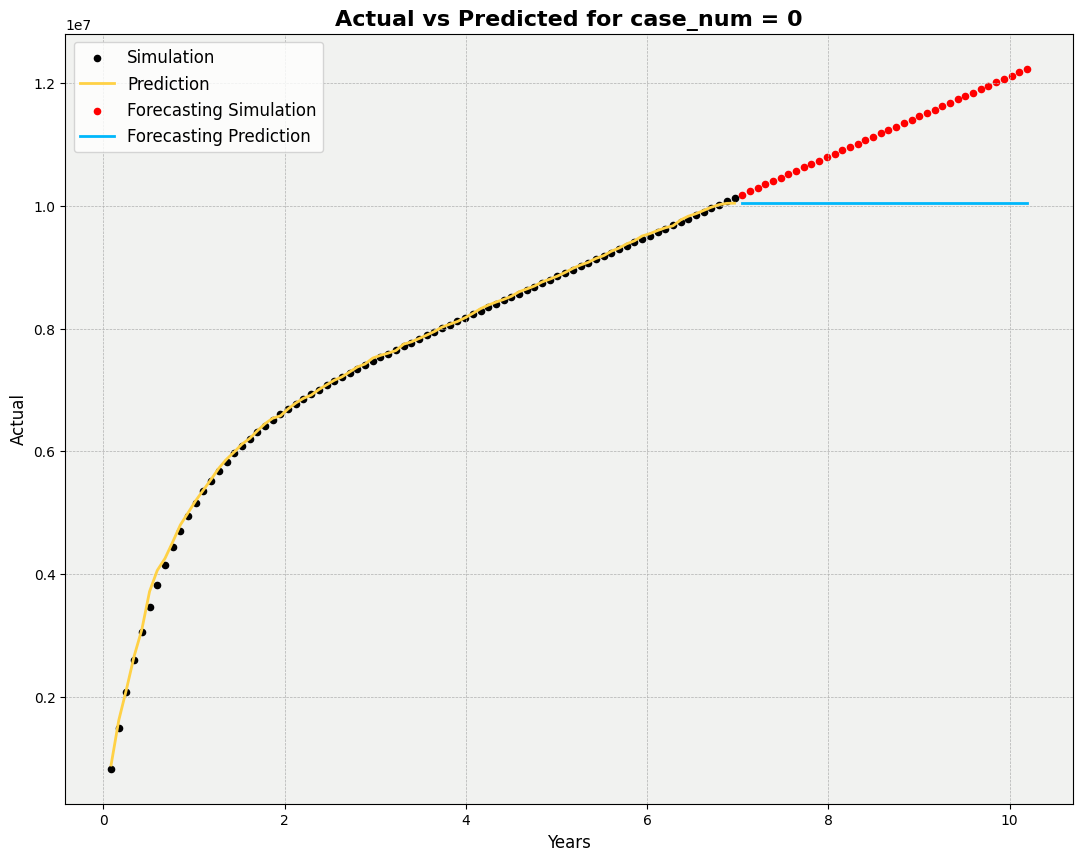

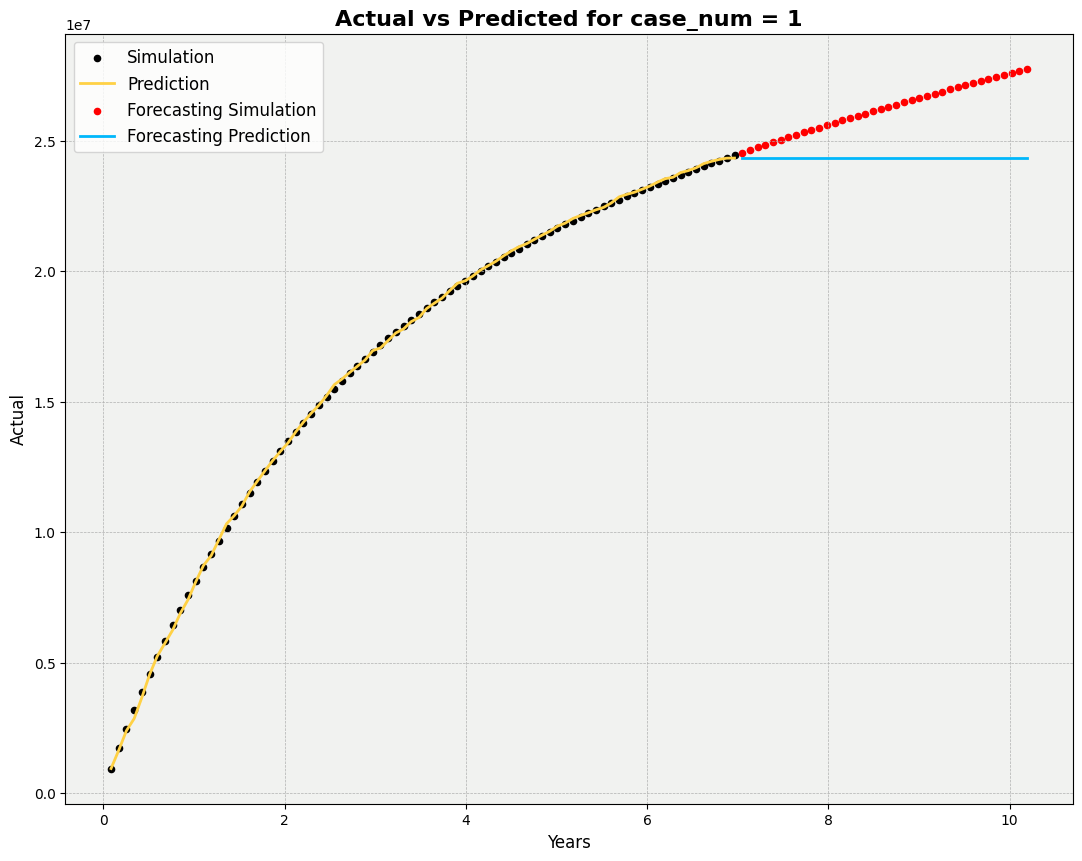

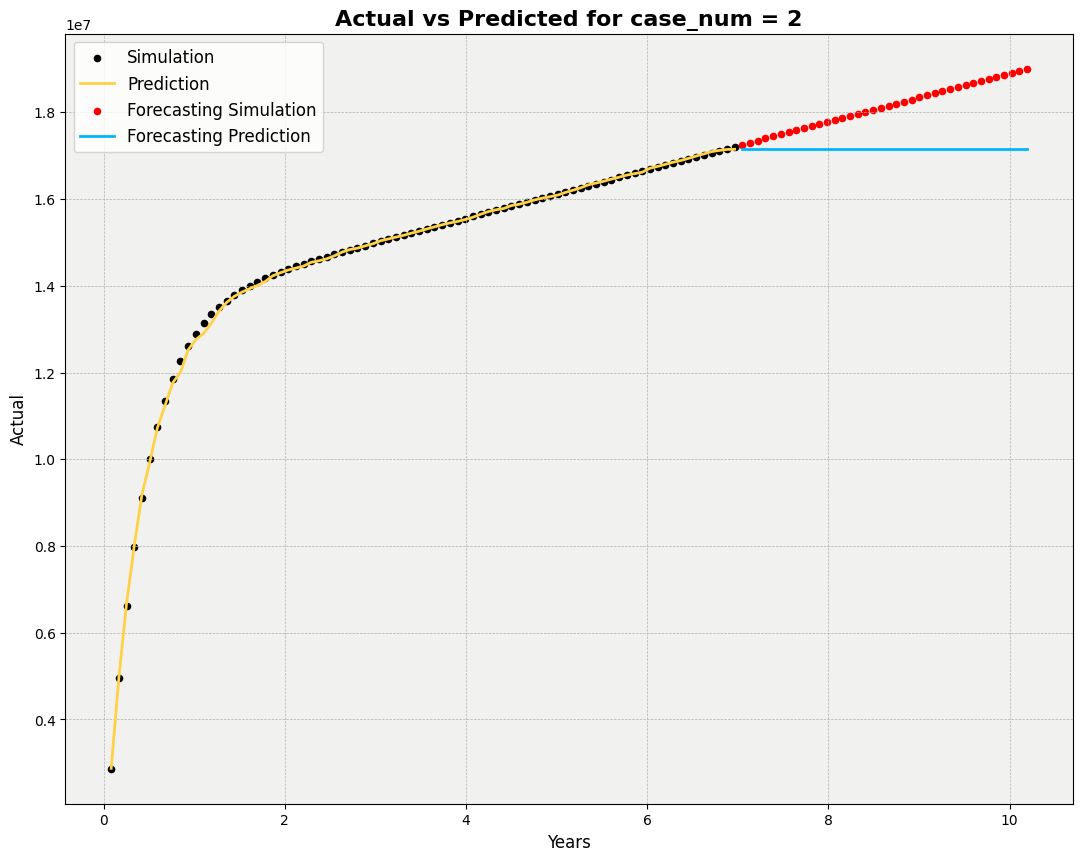

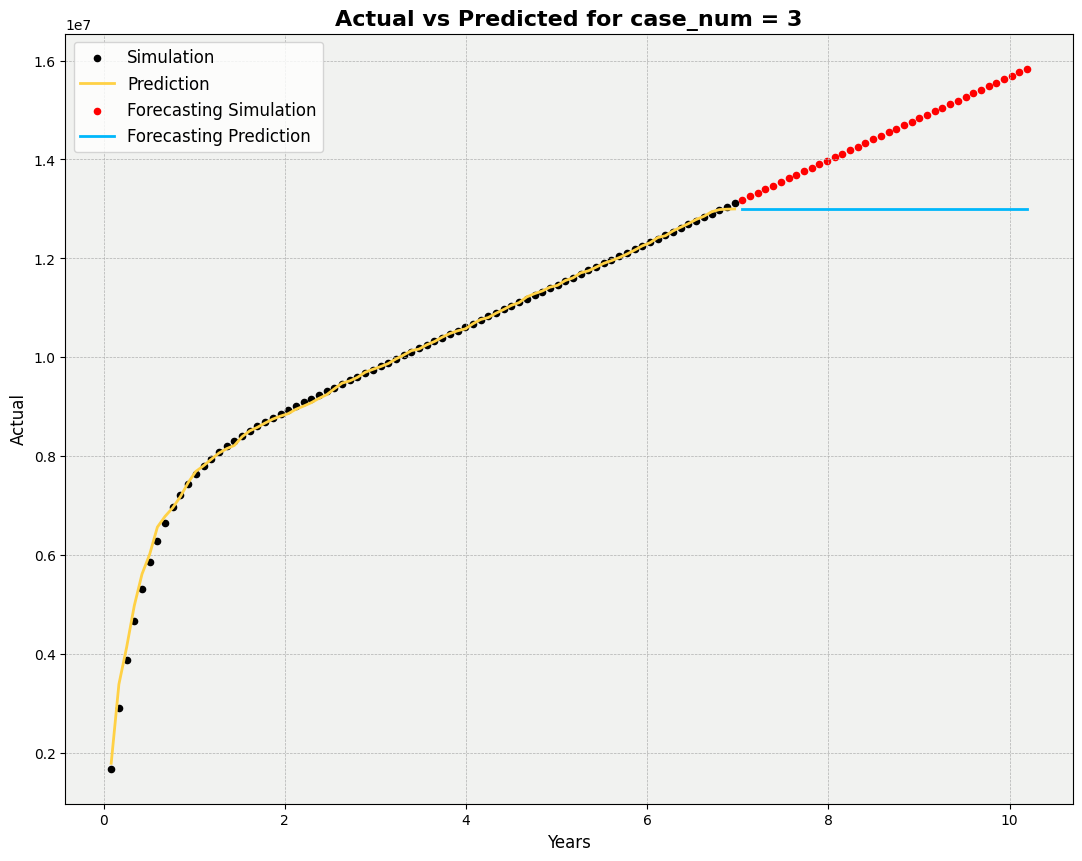

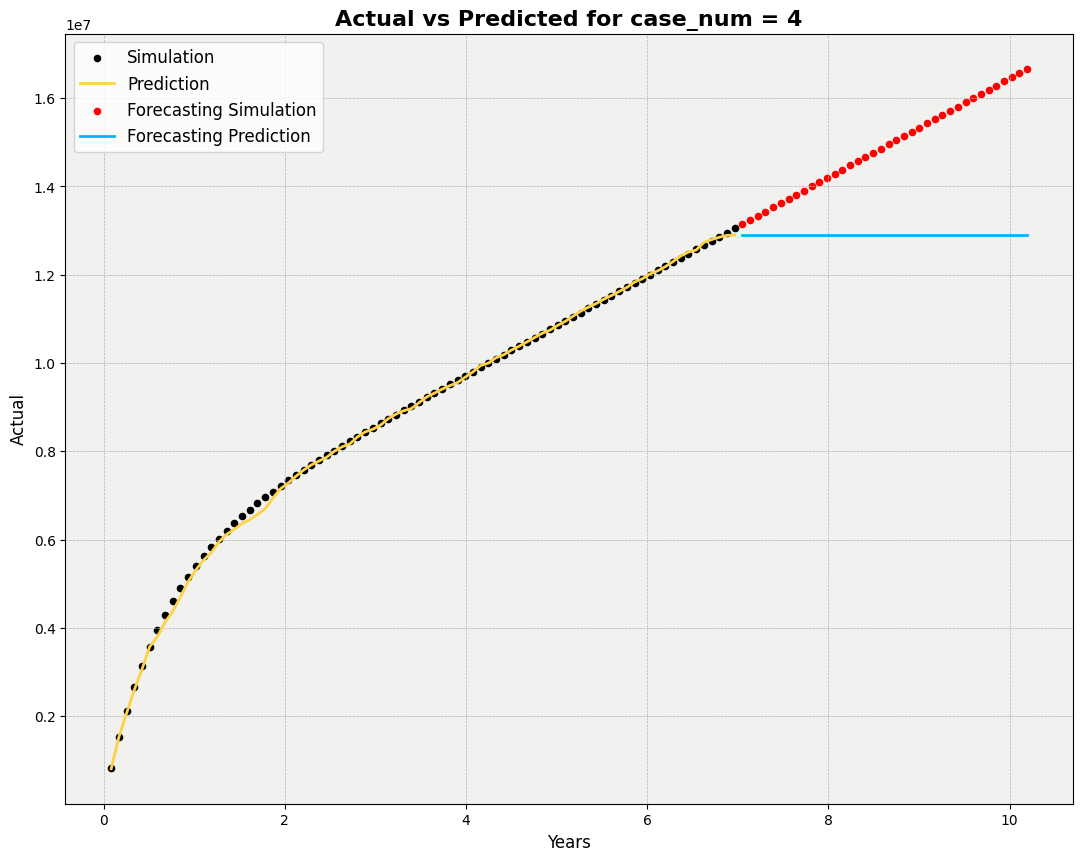

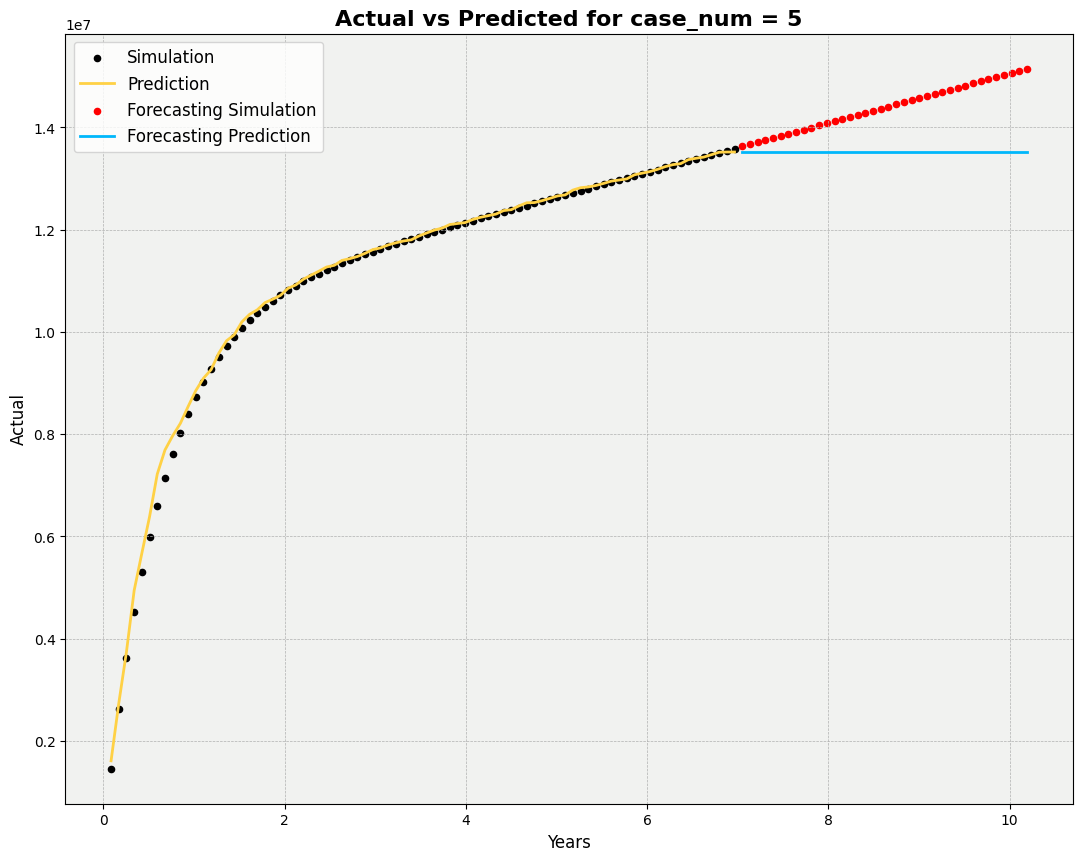

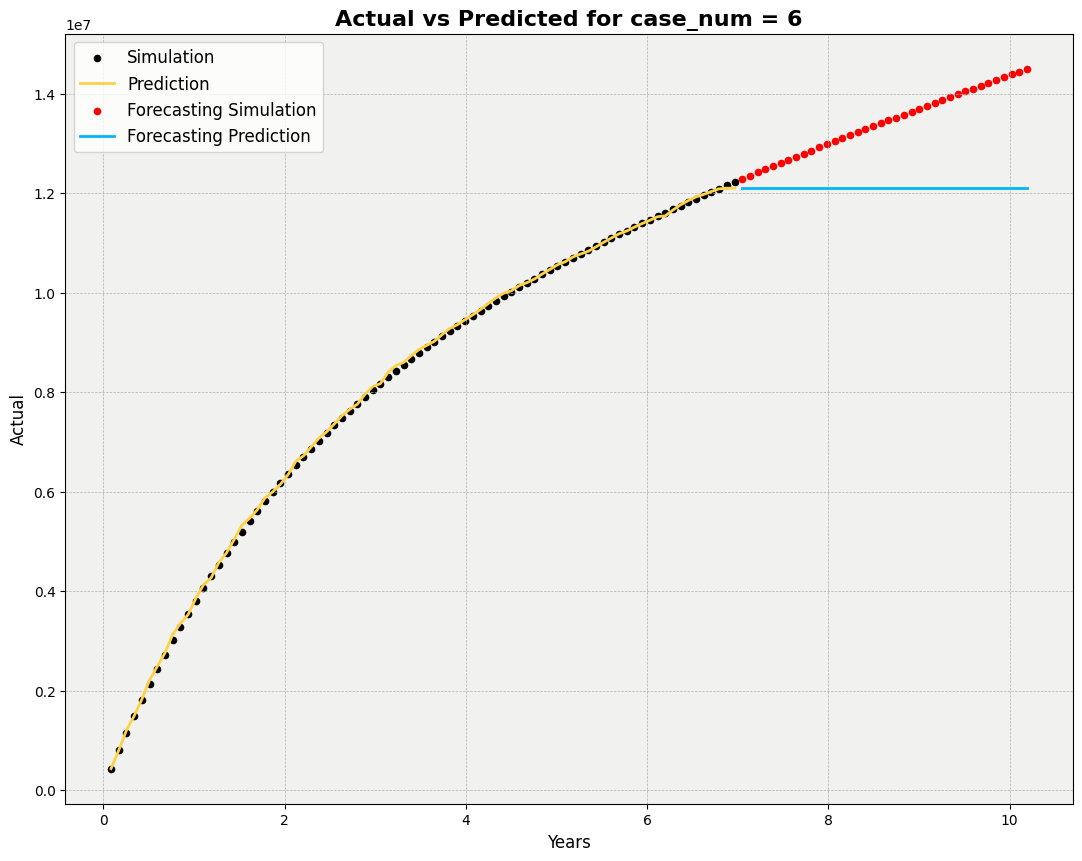

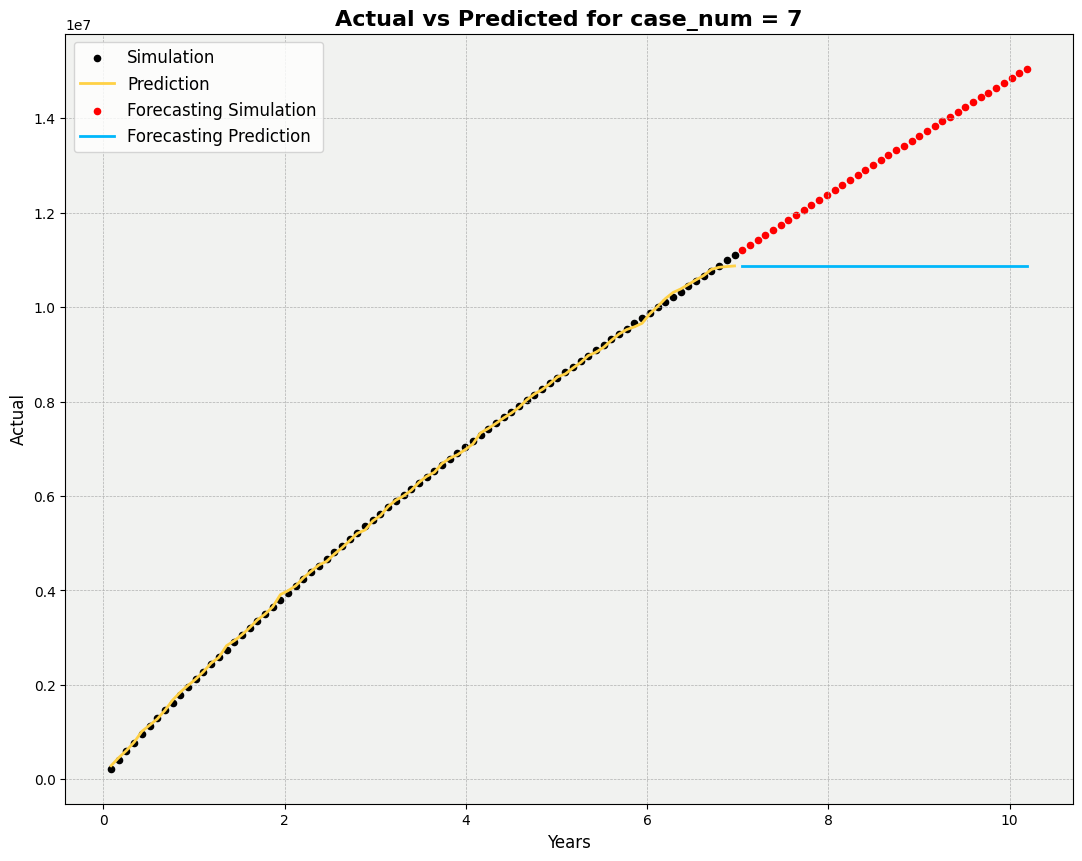

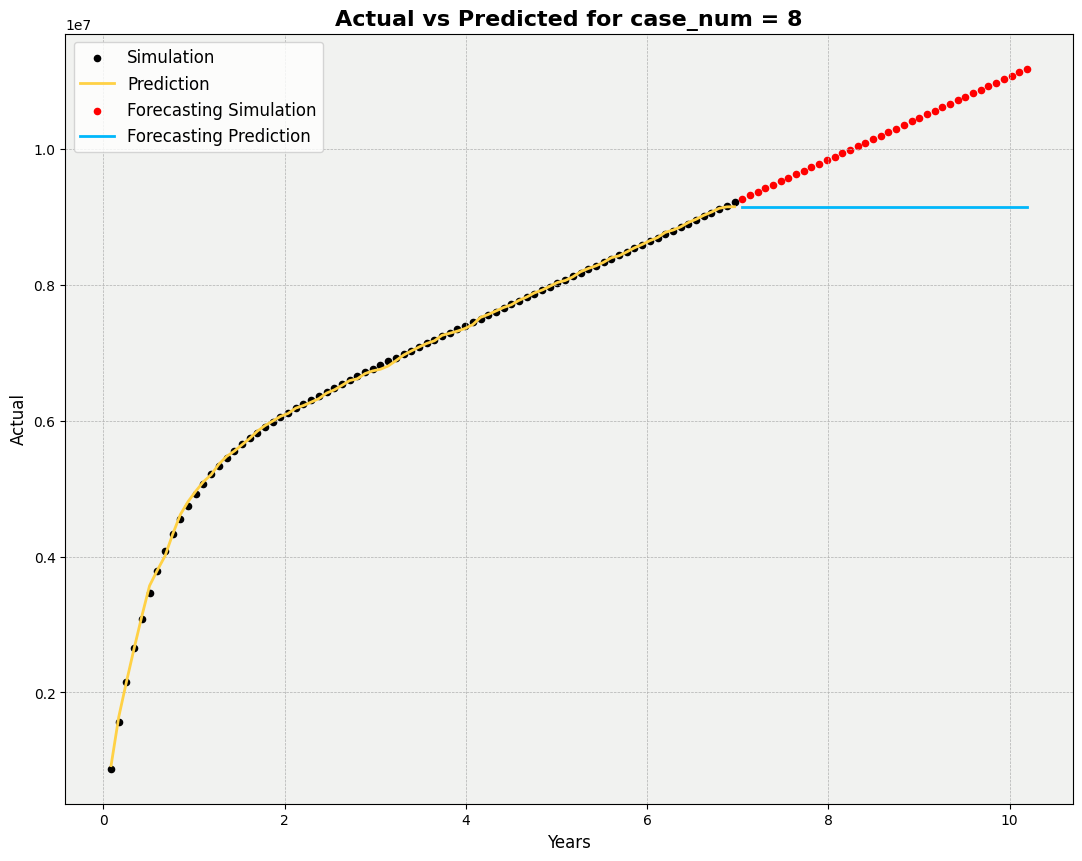

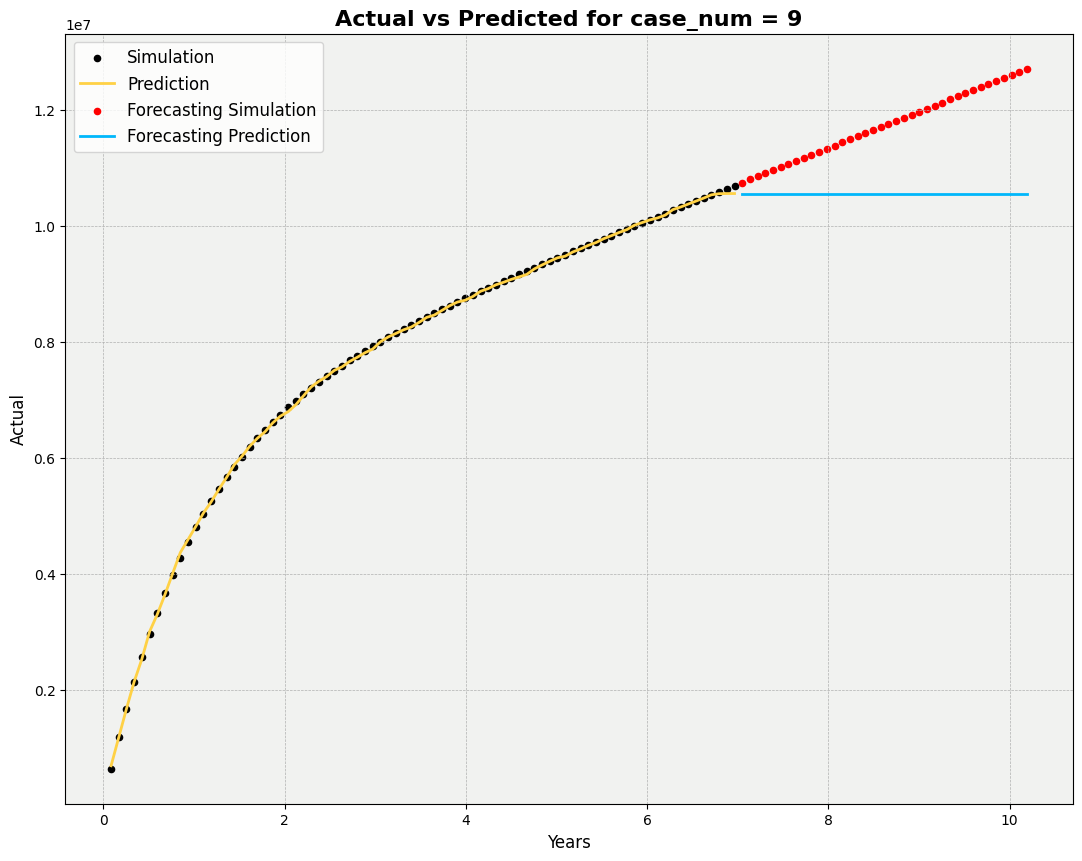

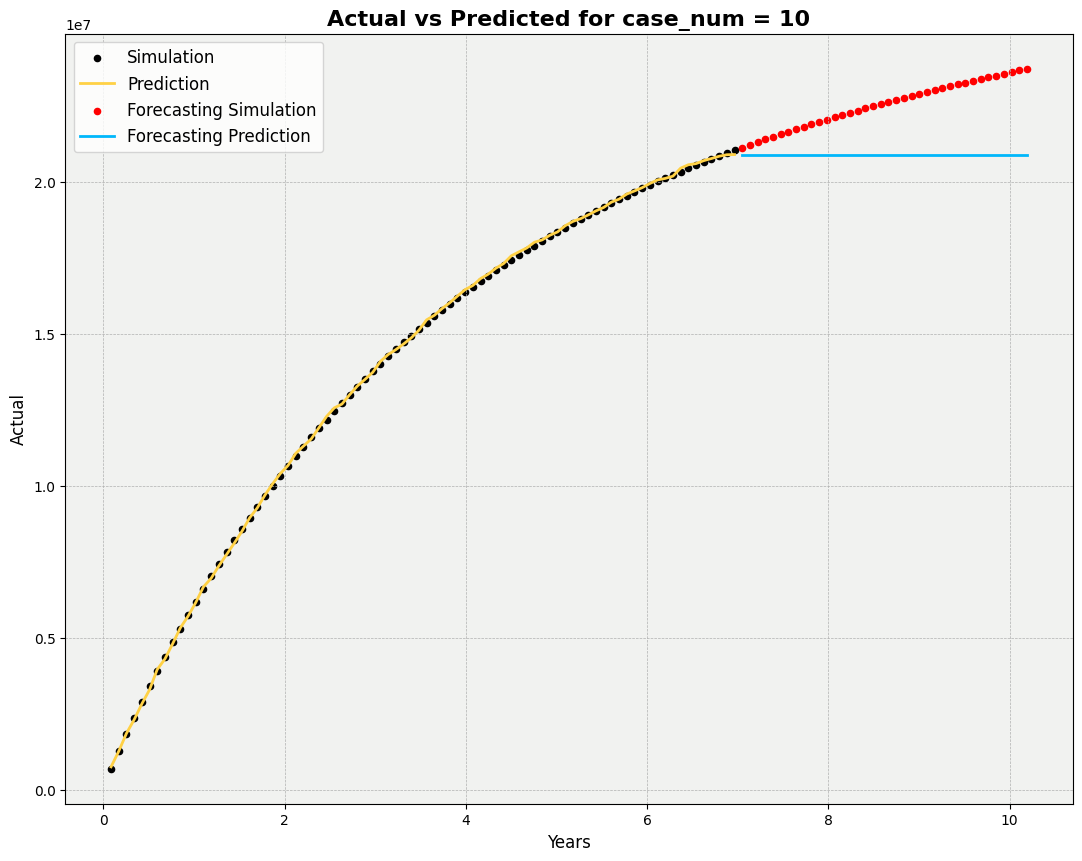

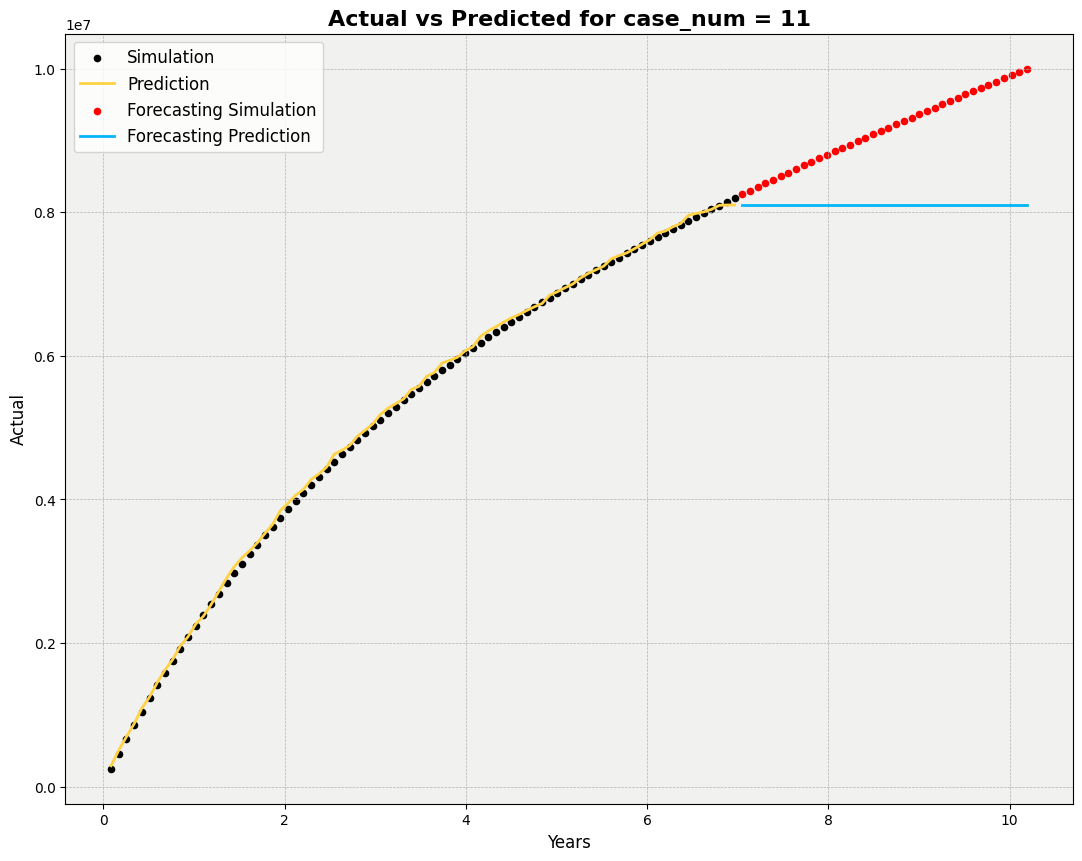

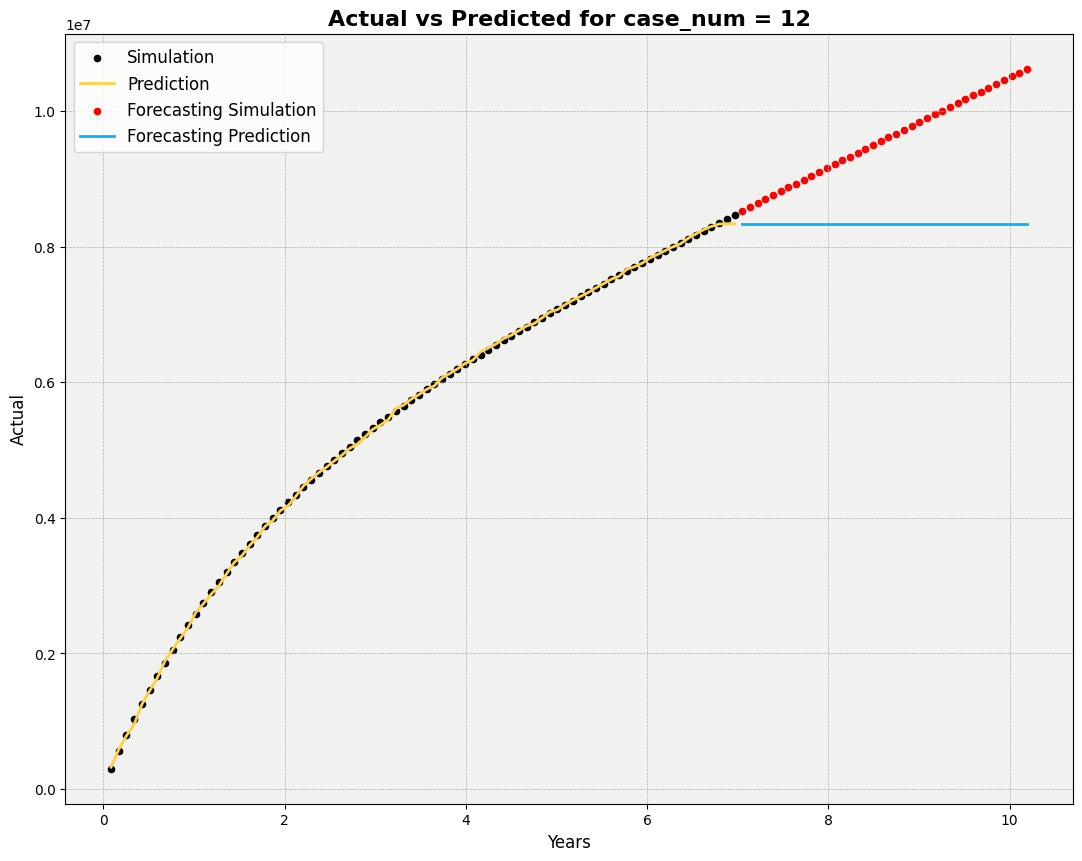

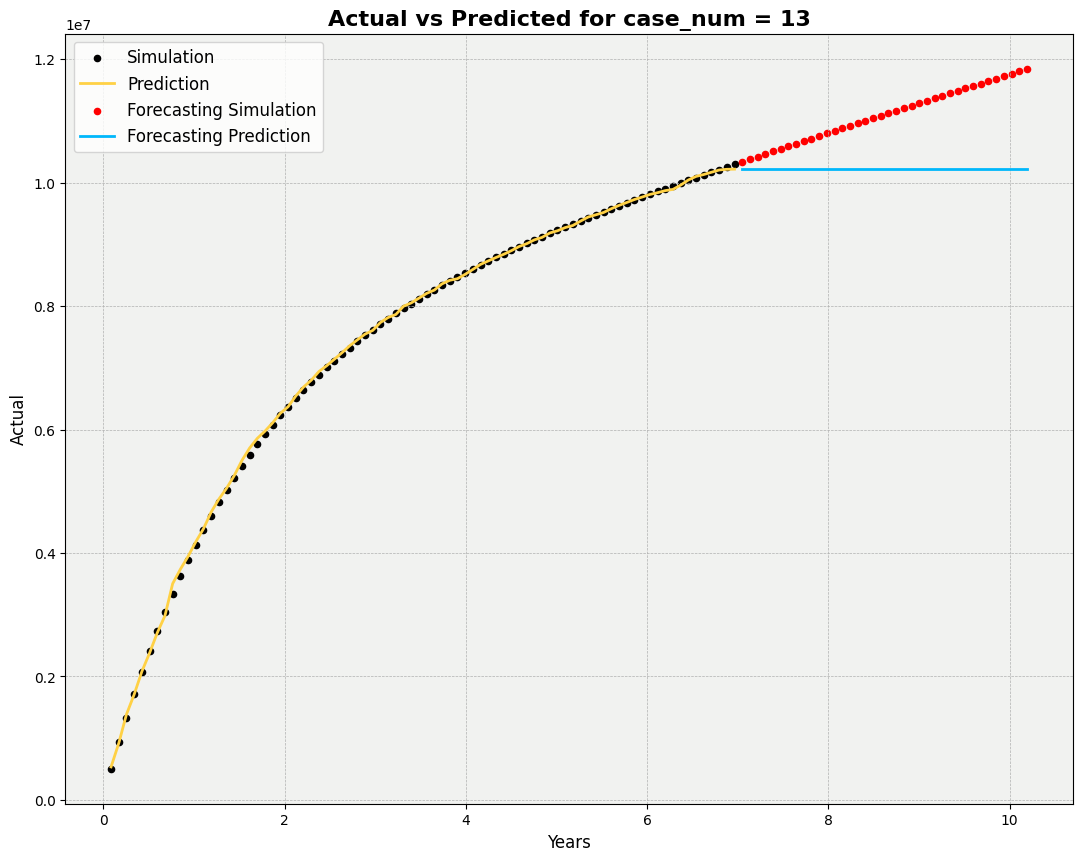

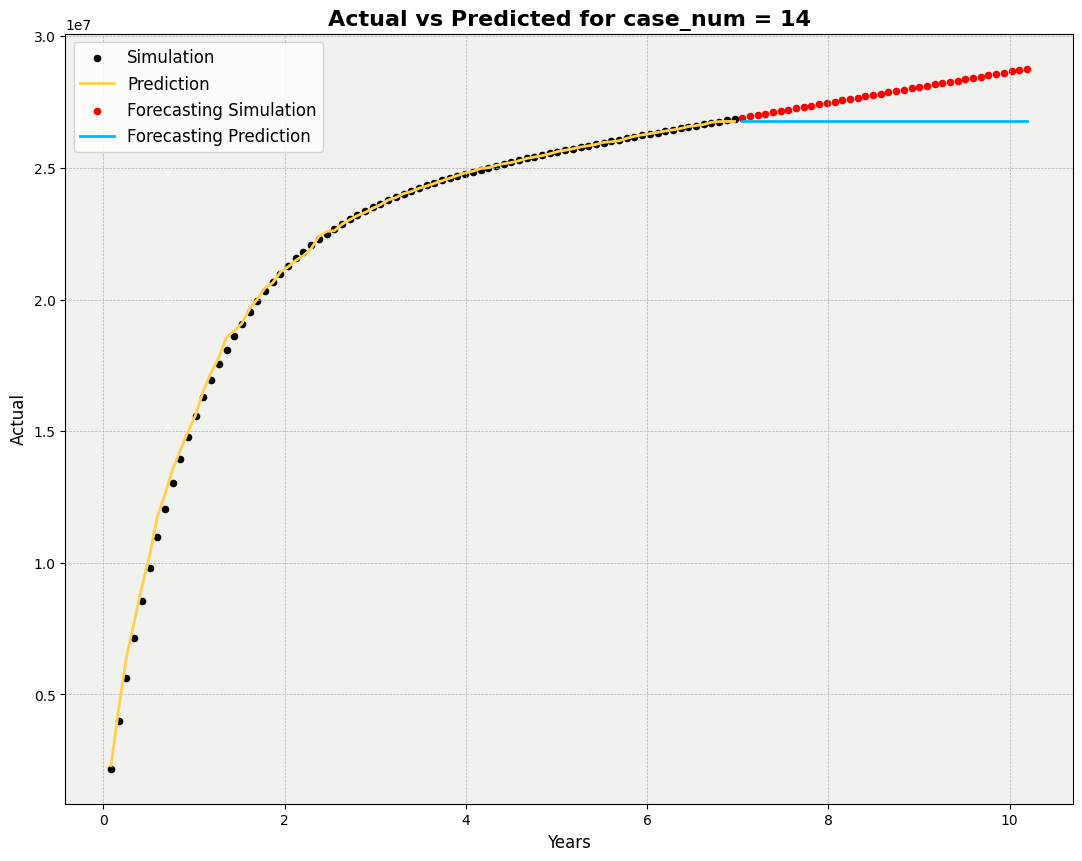

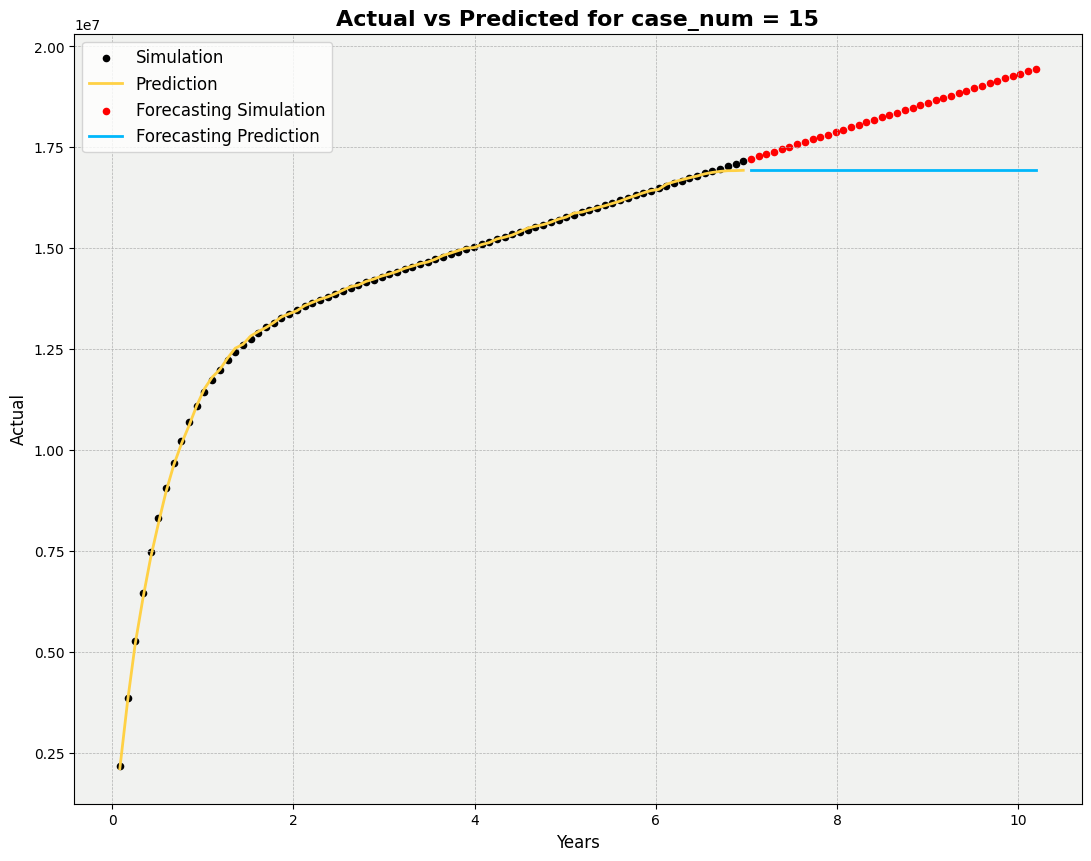

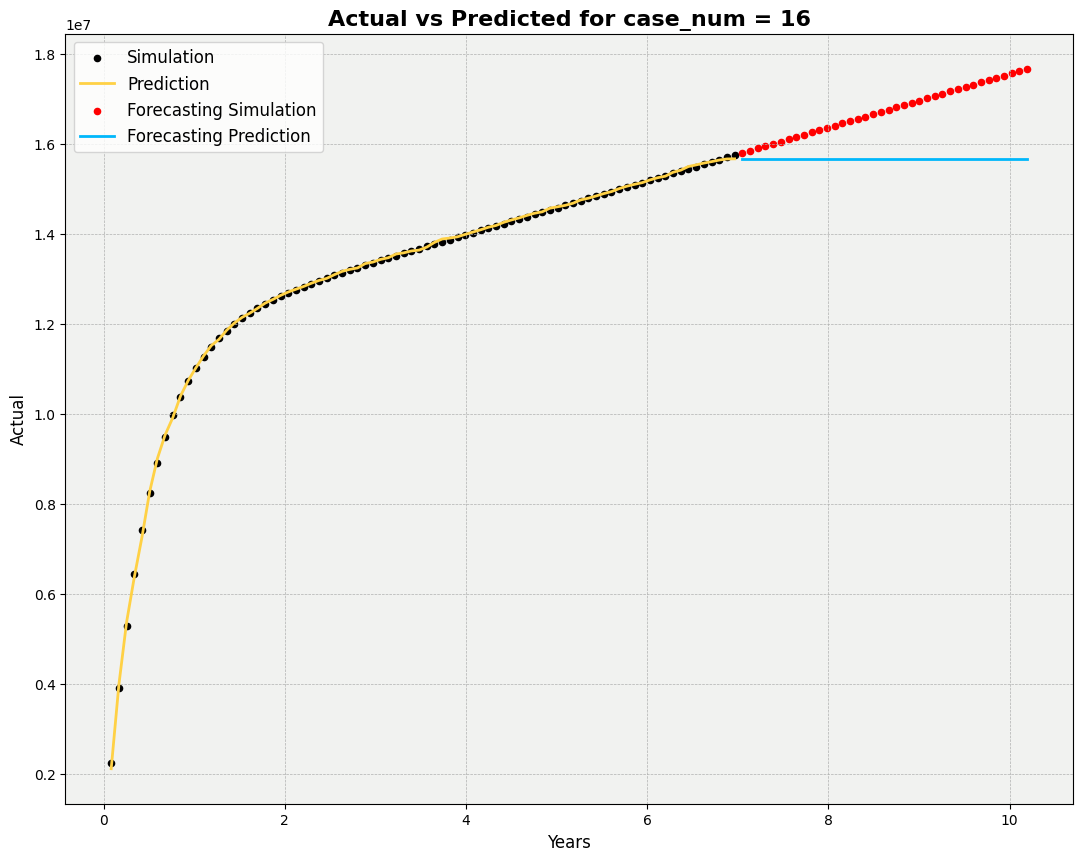

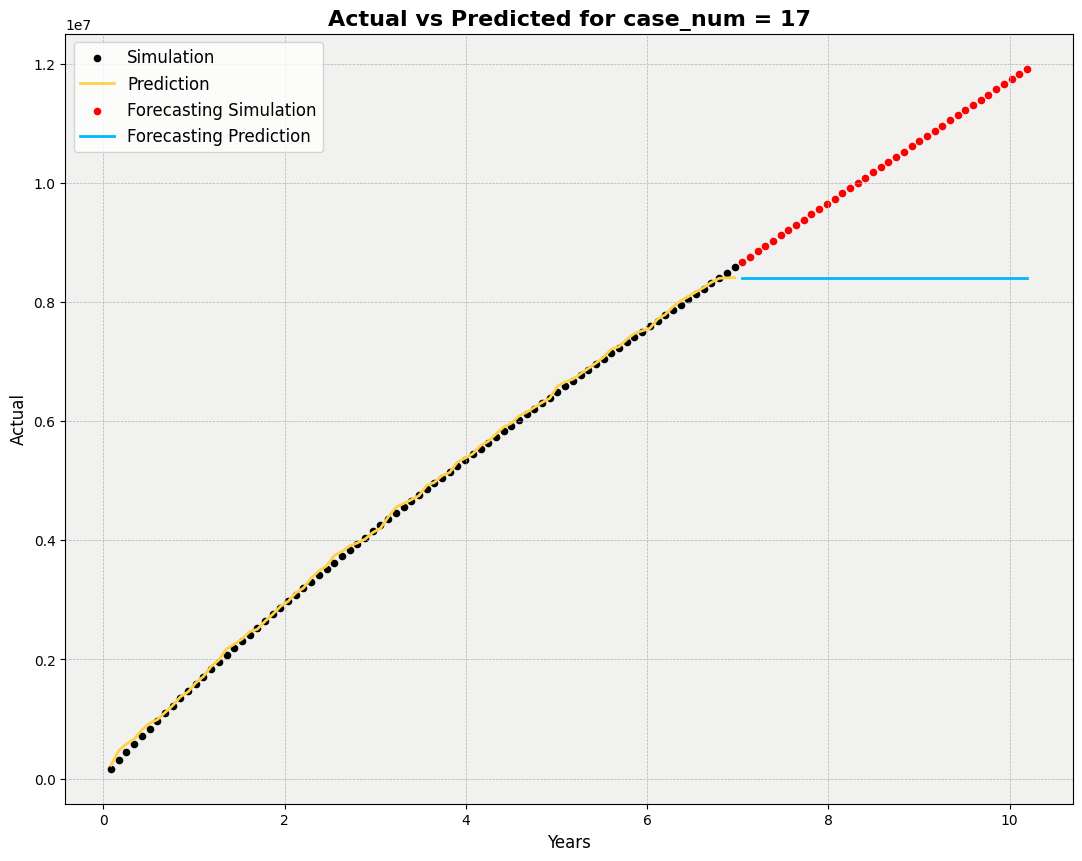

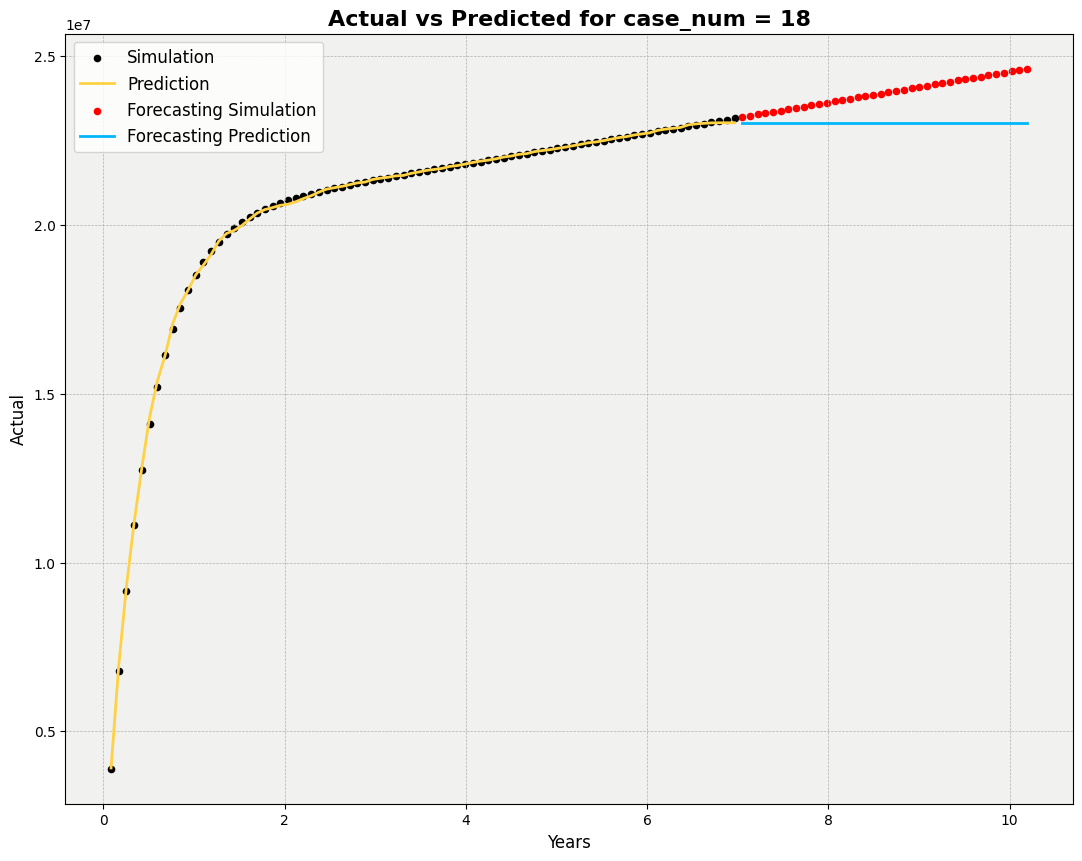

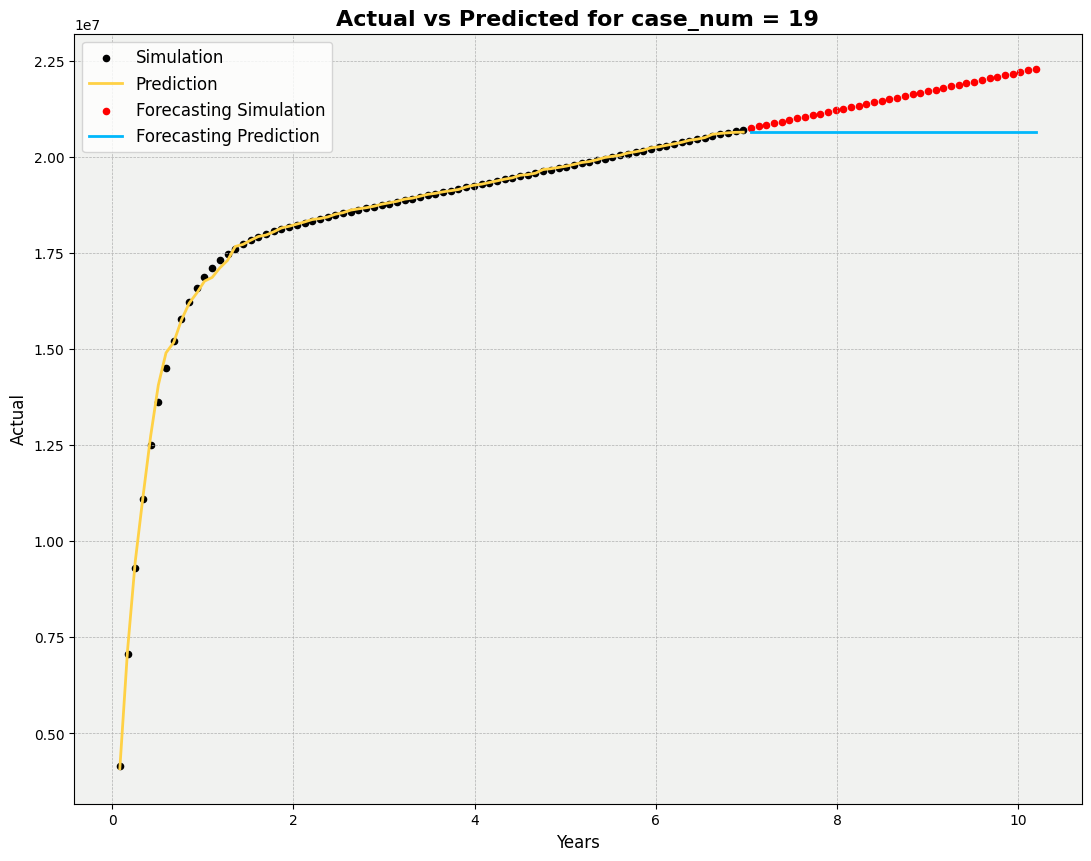

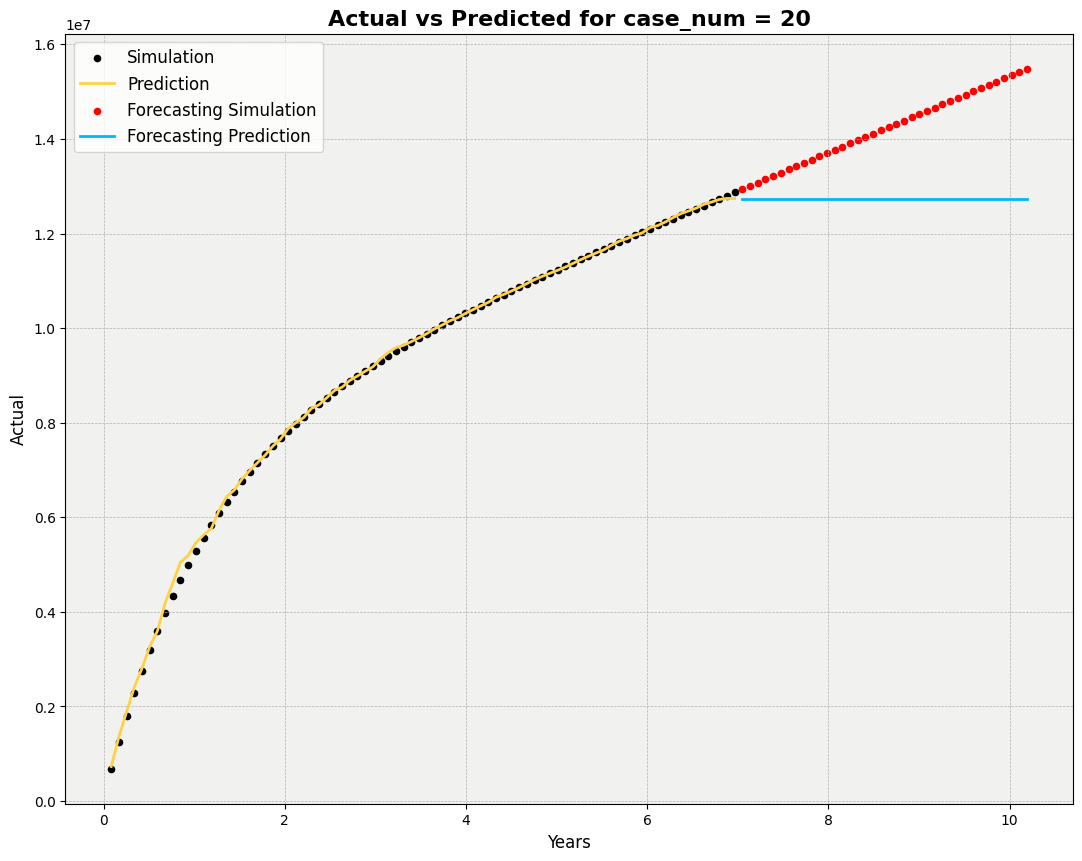

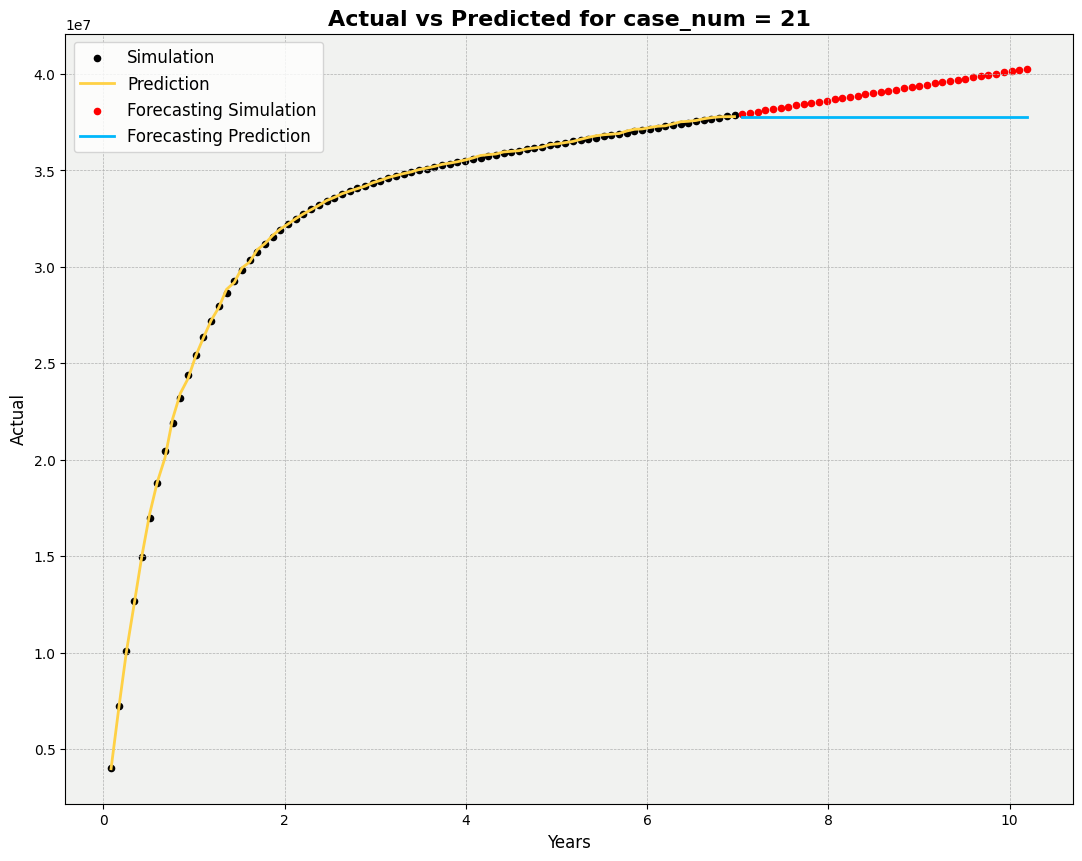

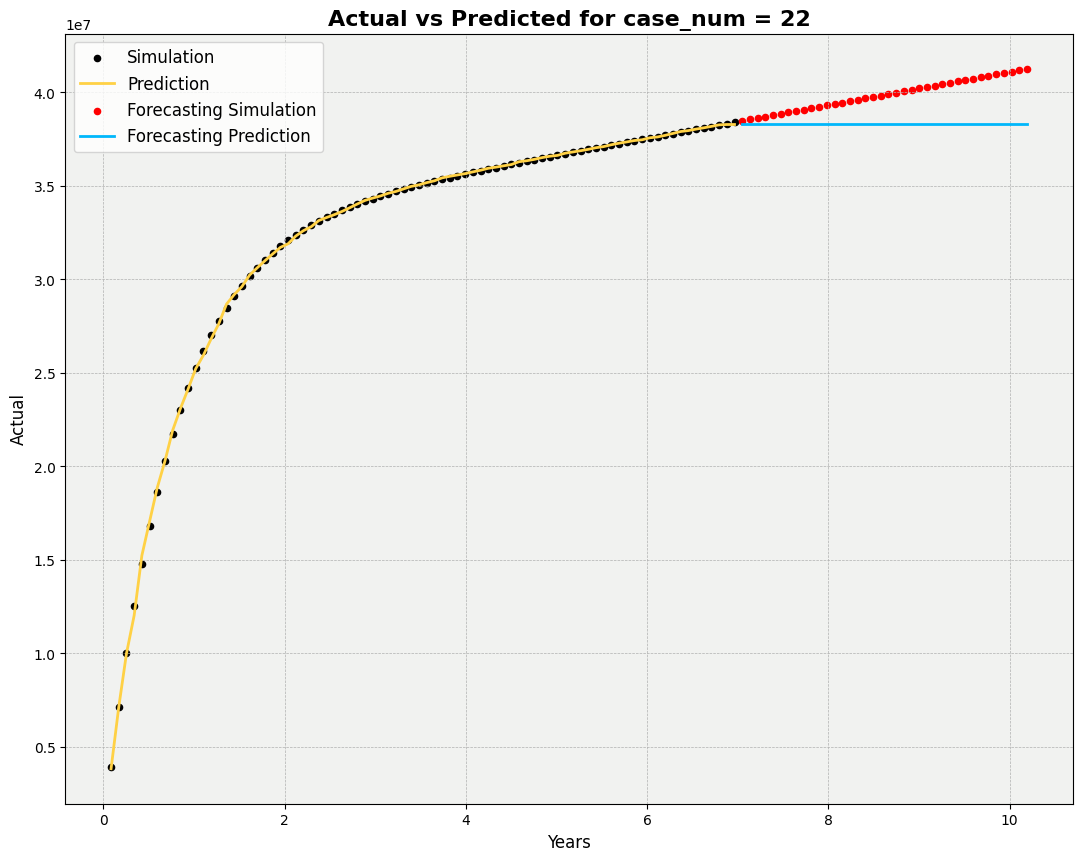

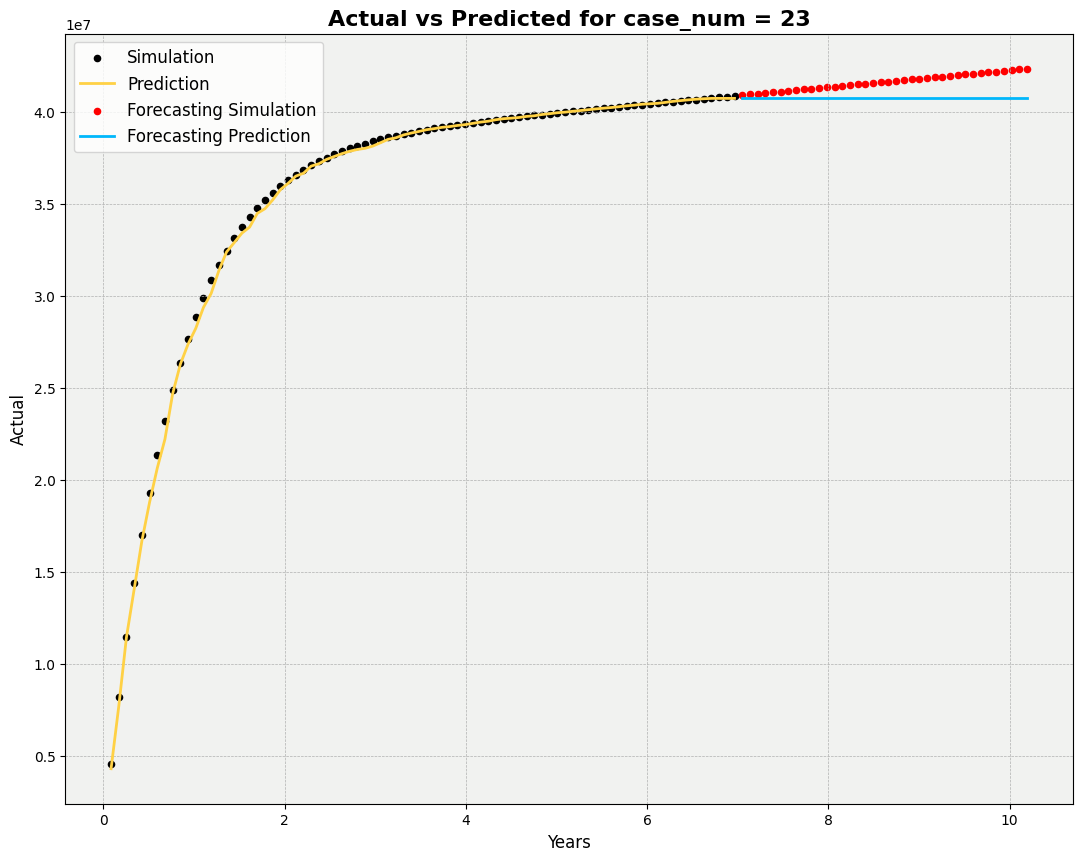

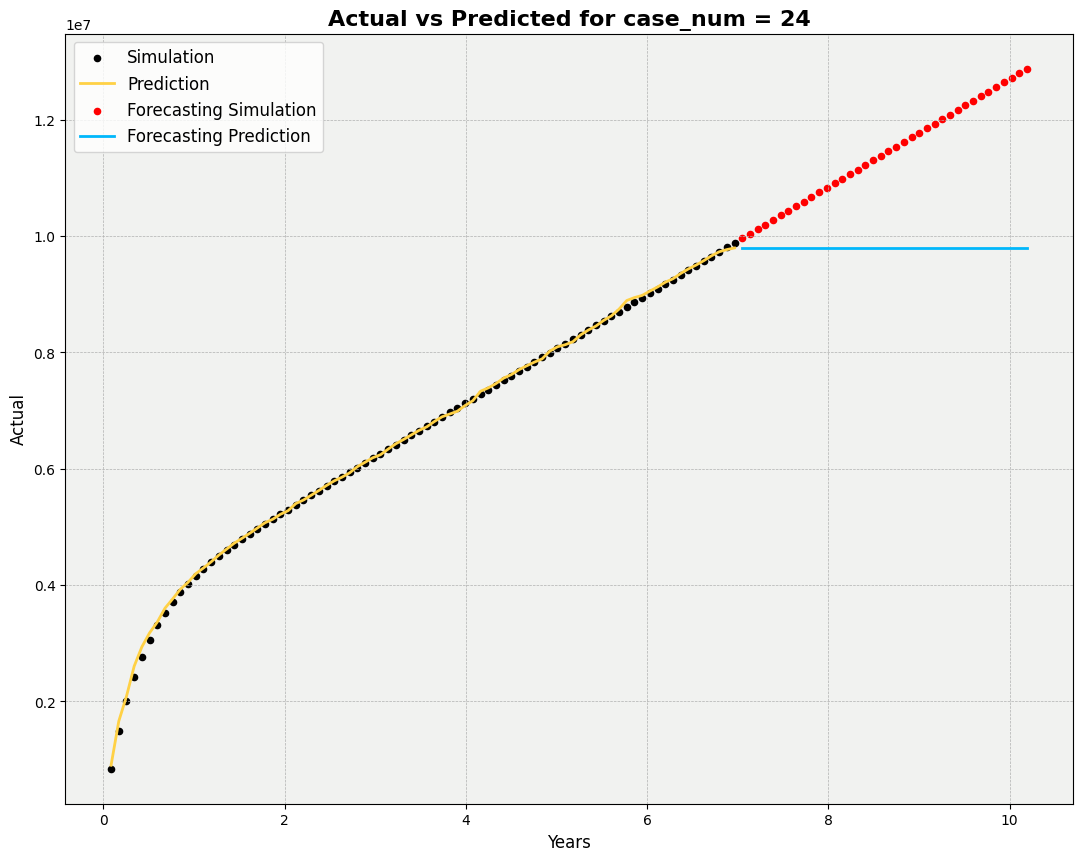

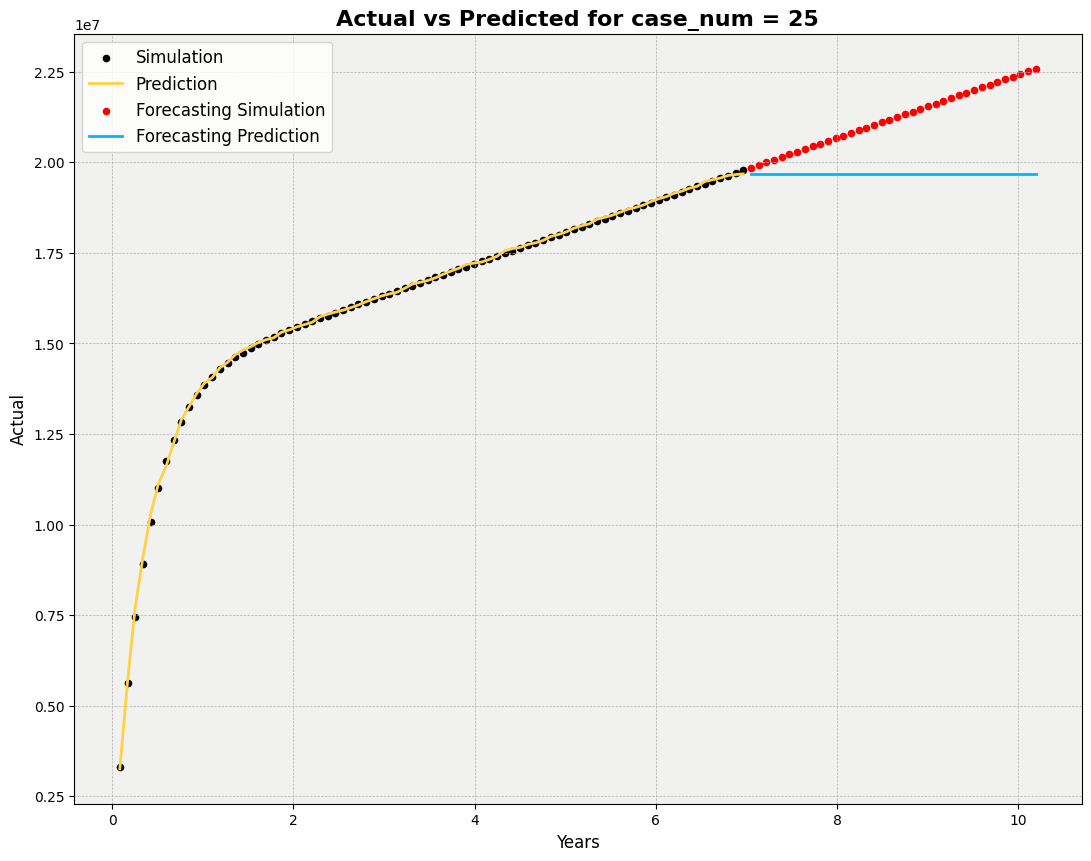

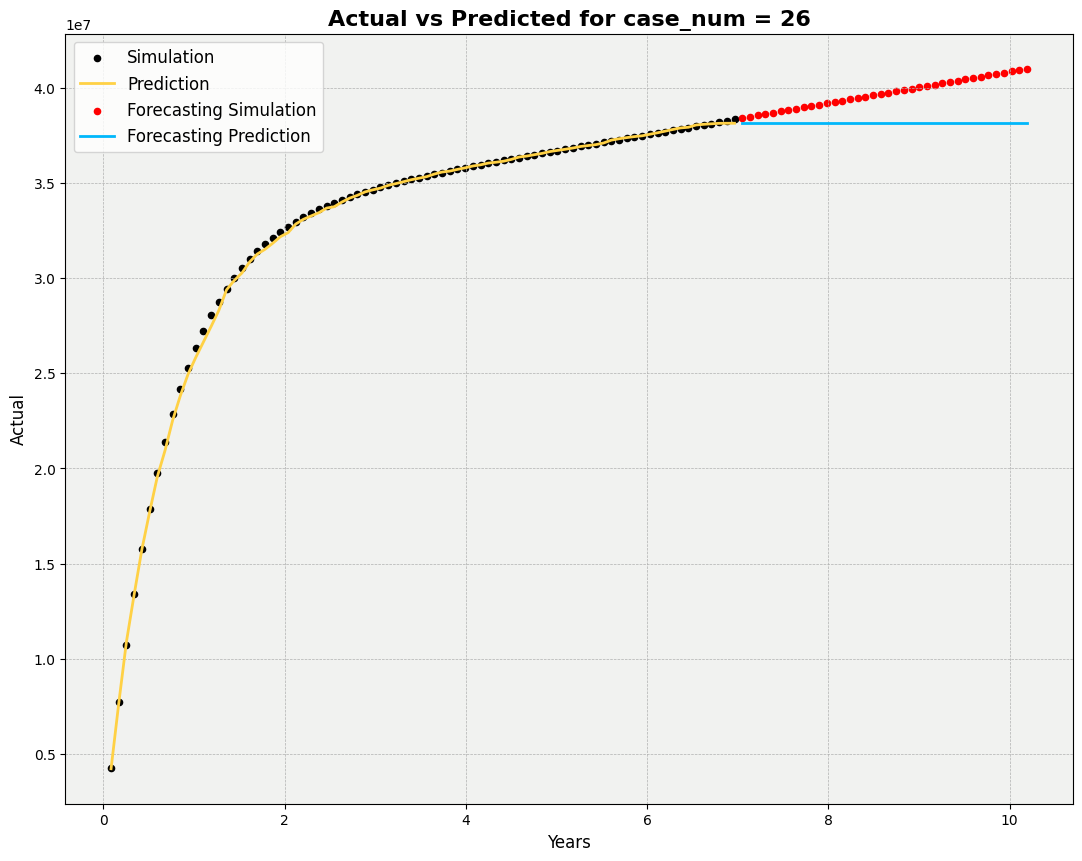

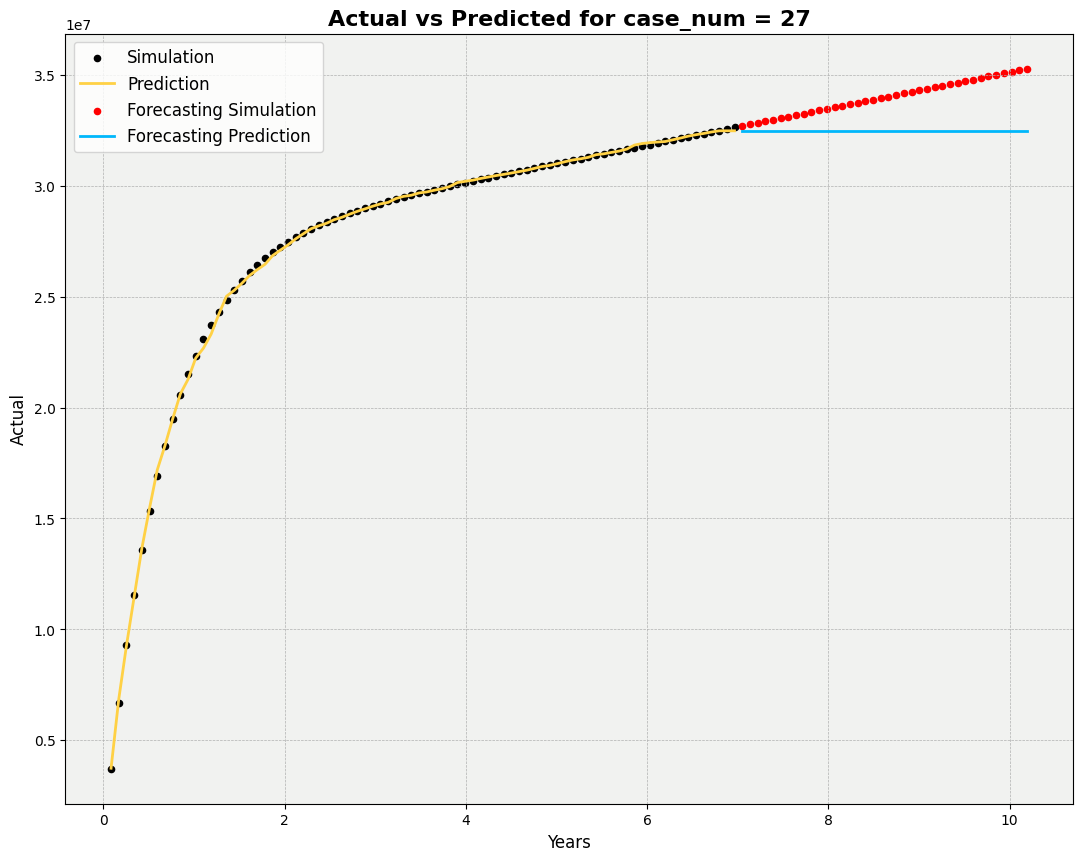

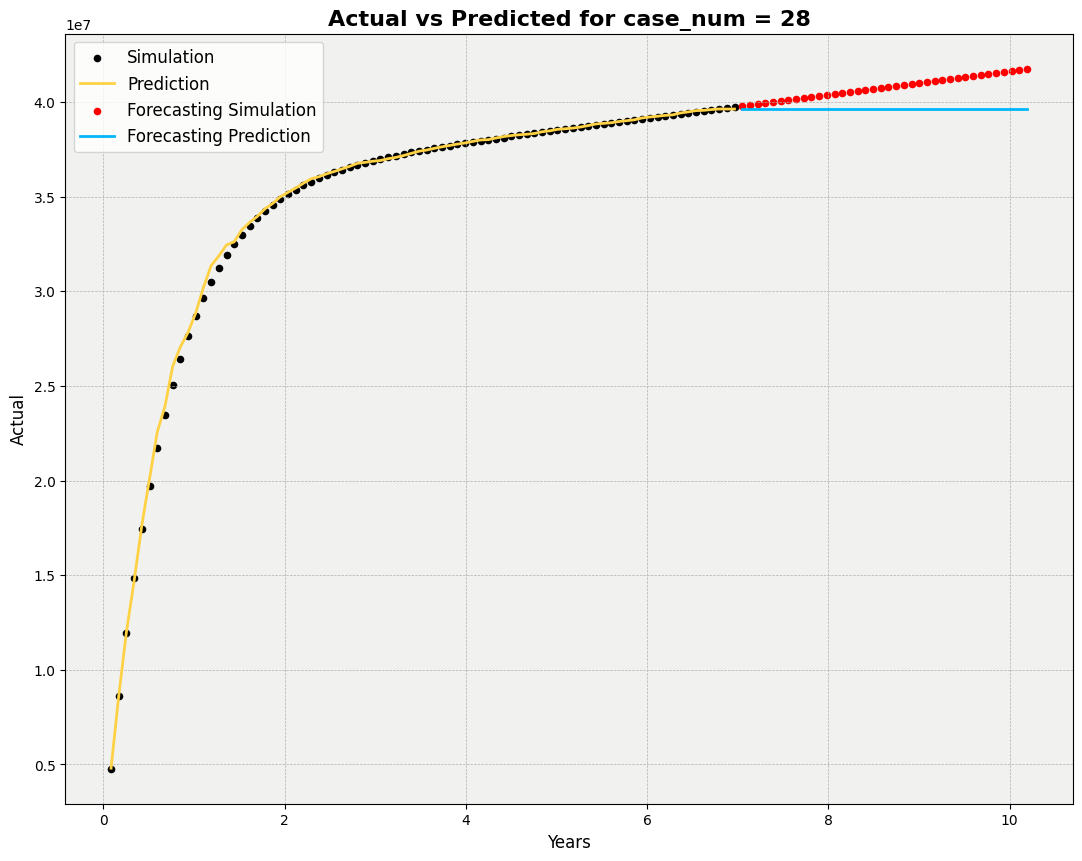

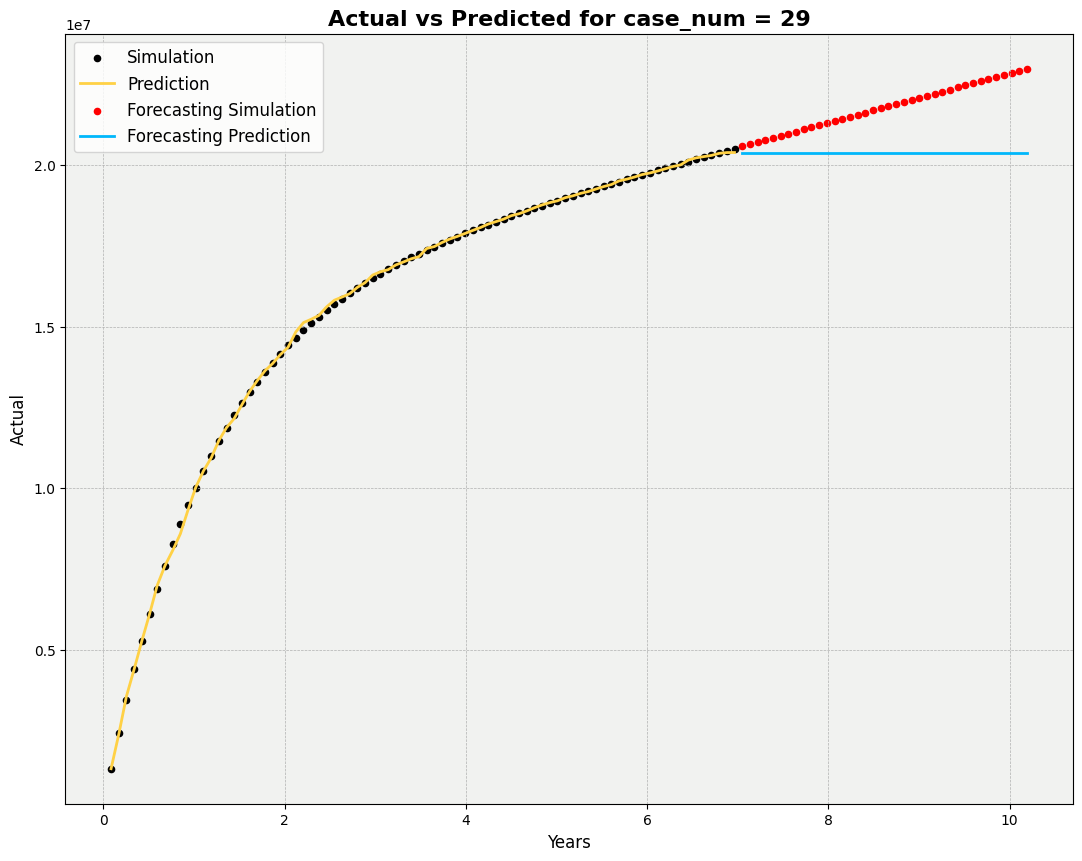

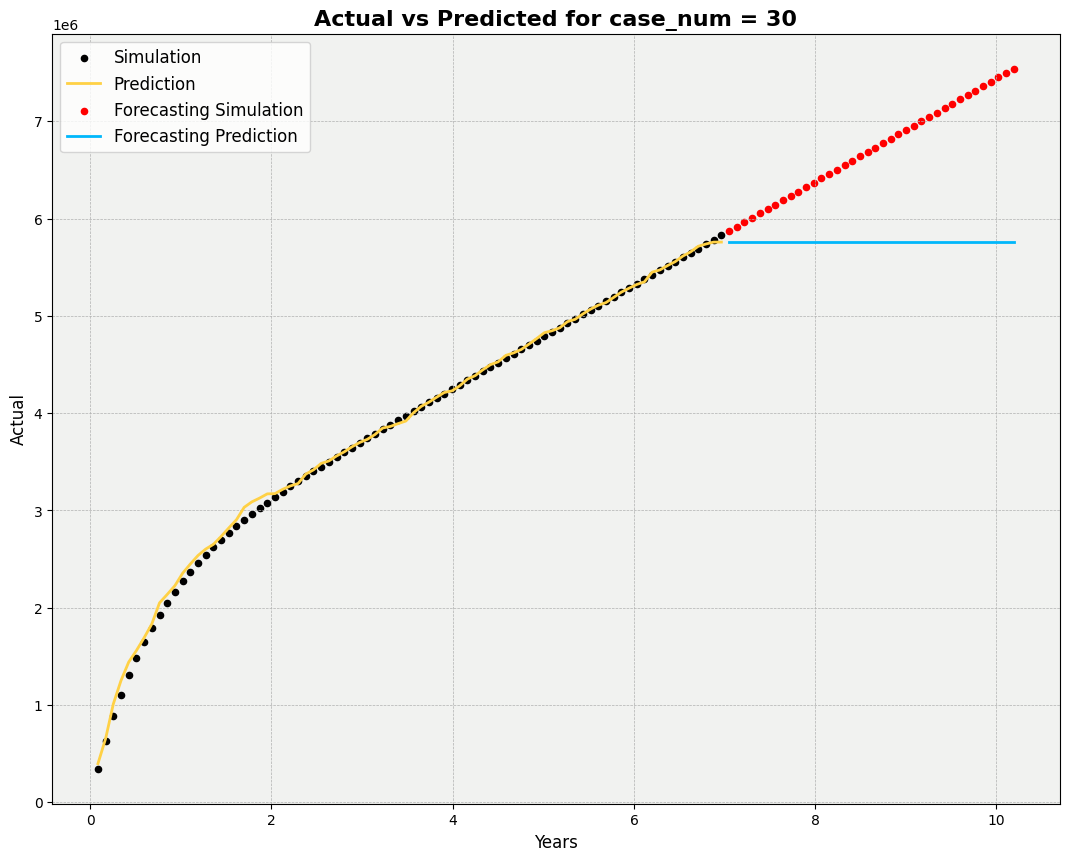

KeyboardInterrupt: ignored

In [322]:
# Get unique values in the "case_num" column
unique_cases = df_prediction2['case_num'].unique()

# Iterate over each unique case_num
for case in unique_cases:
    # Filter the data for the current case_num
    plot_1 = df_prediction2[df_prediction2['case_num'] == case]
    plot_2 = val_pred[val_pred['case_num'] == case]
    
    # Create a new figure for each case_num
    fig, ax1 = plt.subplots(figsize=(13, 10))
    
    # Plot1 scatter for "Actual" column
    ax1.scatter(plot_1['years'], plot_1['Actual'], color='black', s=20, label='Simulation', marker='o')

    # Plot1 line for "Predicted" column
    ax1.plot(plot_1['years'], plot_1['Predicted'], color='#ffd145', linewidth=2, label='Prediction')


    # Plot2 scatter for "Actual" column
    ax1.scatter(plot_2['years'], plot_2['oil_prod_cum'], color='red', s=20, label='Forecasting Simulation', marker='o')

    # Plot2 line for "Predicted" column
    ax1.plot(plot_2['years'], plot_2['Predicted_cum_oil'], color='#00b7fb', linewidth=2, label='Forecasting Prediction')


    ax1.set_xlabel('Years', fontsize=12)
    ax1.set_ylabel('Actual', fontsize=12)

    # Add gridlines
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Customize the title font size and style
    plt.title(f'Actual vs Predicted for case_num = {case}', fontsize=16, fontweight='bold')

    # Customize the legend font size
    plt.legend(loc='upper left', fontsize=12)

    # Customize the tick label font size
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add a background color
    ax1.set_facecolor('#F1F2F0')

    plt.show()

In [200]:
# Bad result is found in the case [17, 11, 7, 6, 1]